# Mode-Turbulence Coupling: Numerical Analysis
# Plots for paper
## Ma = 0.2

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate
from functools import reduce
import statistics

### Physical Parameters

In [2]:
# mach number Ma
Ma = 0.2

### Functions of Ma

In [3]:
Tr = 2*np.pi / Ma

# variables for generating F1
meanF1 = 0
stdF1 = Ma**3 / (2 * np.pi)

# variables for generating F2
meanF2 = 0
stdF2 = Ma**2

### Calculation parameters

In [4]:
L = 10
M = 10**3
# divide T(max), the total duration, into equal segments delt = 2*pi*N
N = 1
# divide the full range alpha_min <= alpha <= alpha_max into m equal intervals
# delalpha = (alpha_max - alpha_min) / m ~ 4/m
m = 100

### Calculation relations

In [5]:
# Tmax = 2 * pi * M
# delt = N * deltaT

### Initial Conditions

In [6]:
# initial conditions A(0)=1/2*stdF2, dA/dT(0)=0
dAdT = 0
AT = 0

In [7]:
n_bins = 200
# n_samples is the number of eddy turnovers
n_samples = 1800

axis_font = {'size':'25'}
title_font = {'size':'30'}

### Functions

In [8]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(Tr, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()

# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html
#deltaT is the length of each eddy turnover
def fundeltaT(n_bins, n_samples):
    rayleigh = np.random.rayleigh(Tr, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's
def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    time=Tturb
    time.pop(-1)
    return Tturb, time

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

# set G1 = 0
def funG1(F1):
    G1=[]
    for i in range(len(F1)):
        G1.append(0)
    return G1



def funAmp(dAdT, AT):

    #A is the amplitude
    A=[]
    #t is time
    t=[]
    #derivA is the derivative of A with respect to time
    derivA=[]
    f1=[]
    g1=[]
    f2=[]
    
    #F2=constant=c
    #1+G1=constant=b
    #F1=constant=a
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        q=1/2*(4*b-a**2)**(1/2)
        
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C0prime=math.exp(-a*Tturb[i]/2)*C0
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        C1prime=math.exp(-a*(Tturb[i])/2)*C1
        
                
        #Ttemp is an array containing the times between each eddy turnover 
        #(which starts at 0 and ends at deltaT)
        Ttemp=np.linspace(0, deltaT[i])
        
        #this for loop below loops through each eddy turnover:
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(Tturb[i]+j)
                f1.append(a)
                g1.append(b-1)
                f2.append(c)
                
                A.append(math.exp(-a*j/2)*(C0prime*math.sin(q*(Tturb[i]+j))+C1prime*math.cos(q*(Tturb[i]+j)))+c/b)
                derivA.append(math.exp(-a*j/2)*((C0prime*q-C1prime*a/2)*math.cos(q*(Tturb[i]+j))-(C0prime*a/2+C1prime*q)*math.sin(q*(Tturb[i]+j))))
                
        #resets the initial conditions for the next eddy turnovers to match the conditions at the end of the previous eddy turnover
        dAdT=derivA[-1]
        AT=A[-1]
            
    
    return A, t, f1, g1, f2

In [9]:
# Average value of Amplitude
def FunAsqr(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    return Asqr

# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

# 1/2*log(A^2)
# same as log(abs(A)) above
def FunHalfLogASqr(A):
    logAsqr = []
    for i in A:
        logAsqr.append(1/2*math.log10(i*i))
    return logAsqr

# Root mean square
def FunRMS(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = np.sum(Asqr) / len(Asqr)
    RMS = avg**(1/2)
    return RMS
    

In [10]:
def Funplots(t, A, f1, f2):

    plt.figure(figsize=(40,10))
    plt.plot(t, A, 'k')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F1', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F2', **axis_font)
    plt.tight_layout()
    plt.show()

### Parameters

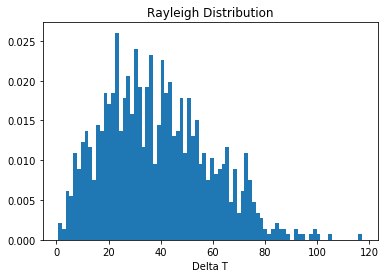

In [11]:
rayleighdistribution()

deltaT = fundeltaT(n_bins, n_samples)

Tturb, time = funTturb()

t = funt()

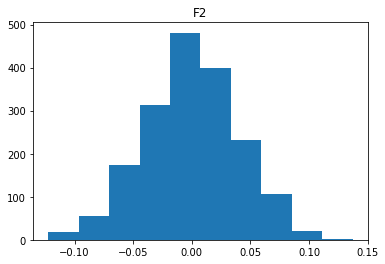

<F2^2>^(1/2) =  0.03956995110166469
Average Value of F2  -0.00013446657982797402
Maximum Value of F2  0.1371983130772355
Minimum Value of F2  -0.12245901286360047


In [12]:
F2 = np.random.normal(meanF2, stdF2, size=len(deltaT))
plt.hist(F2, 10)
plt.title("F2")
plt.show()

F2sqr=[]
for i in range(len(F2)-1):
    F2sqr.append(F2[i]**2)

rms=(sum(F2sqr) / len(F2sqr) )**(1/2)
print("<F2^2>^(1/2) = ", rms)
avgF2 = sum(F2) / len(F2)
print("Average Value of F2 ", avgF2)
print("Maximum Value of F2 ", max(F2))
print("Minimum Value of F2 ", min(F2))

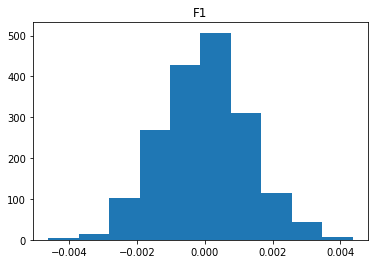

<F1^2>^(1/2) =  0.0012726719078289027
Average Value of F1  -7.923104279856404e-06
Maximum Value of F2  0.004359962680183994
Minimum Value of F1  -0.004618118149315542


In [13]:
F1= np.random.normal(meanF1, stdF1, size=len(deltaT))
plt.hist(F1, 10)
plt.title("F1")
plt.show()

F1sqr=[]
for i in range(len(F1)-1):
    F1sqr.append(F1[i]**2)

rms=(sum(F1sqr) / len(F1sqr) )**(1/2)
print("<F1^2>^(1/2) = ", rms)

avgF1 = sum(F1) / len(F1)
print("Average Value of F1 ", avgF1)

print("Maximum Value of F2 ", max(F1))
    
print("Minimum Value of F1 ", min(F1))

In [14]:
G1 = funG1(F1)

##  Amplitude of mode, F1, F2, log(A) vs. Time

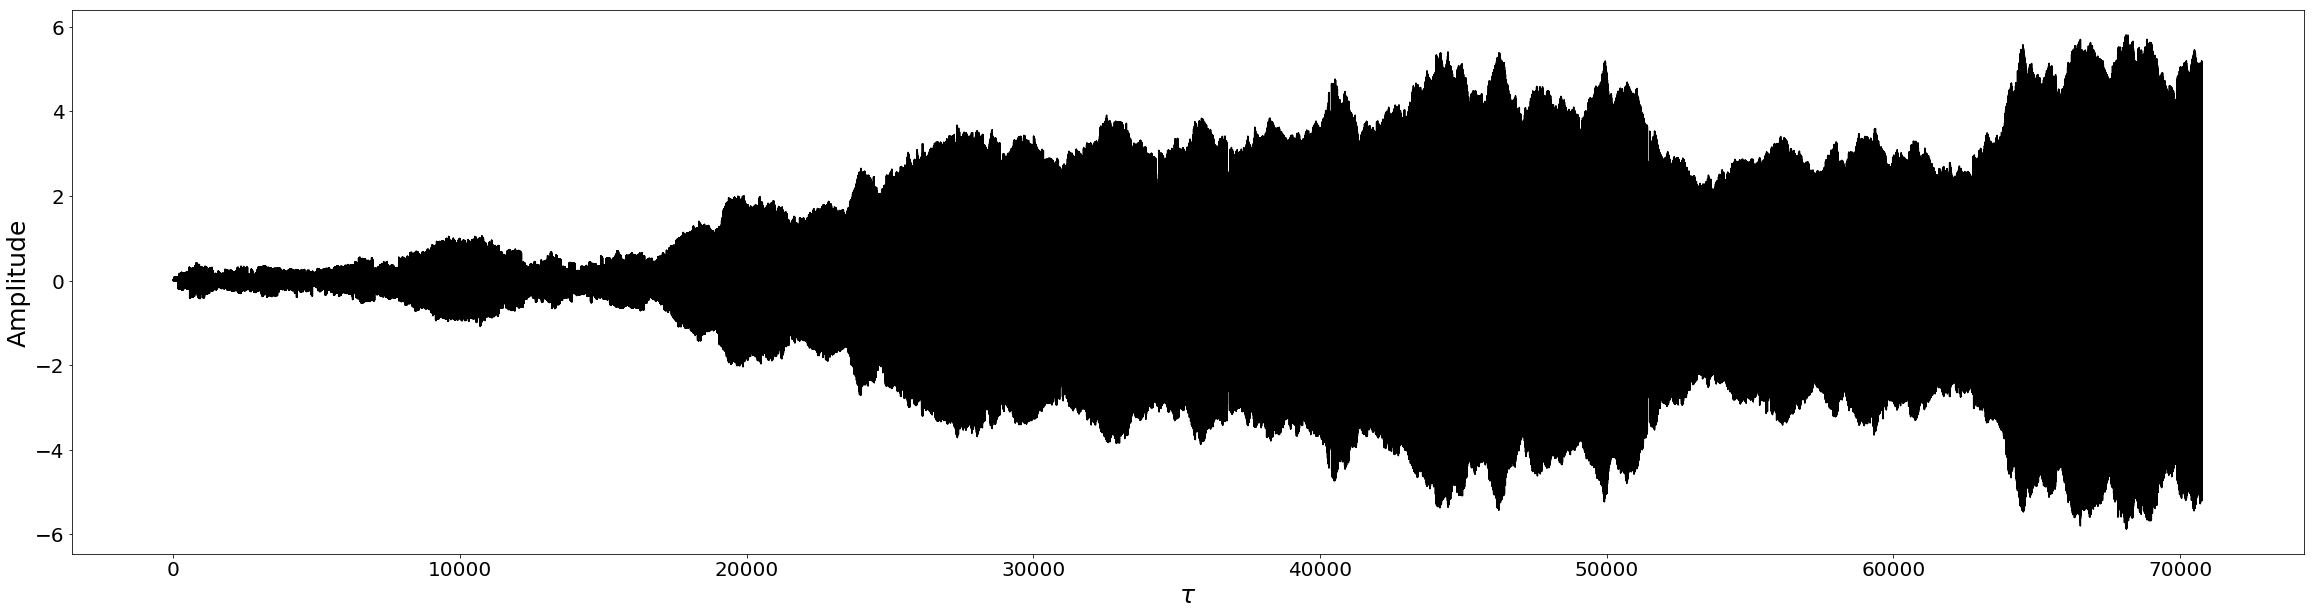

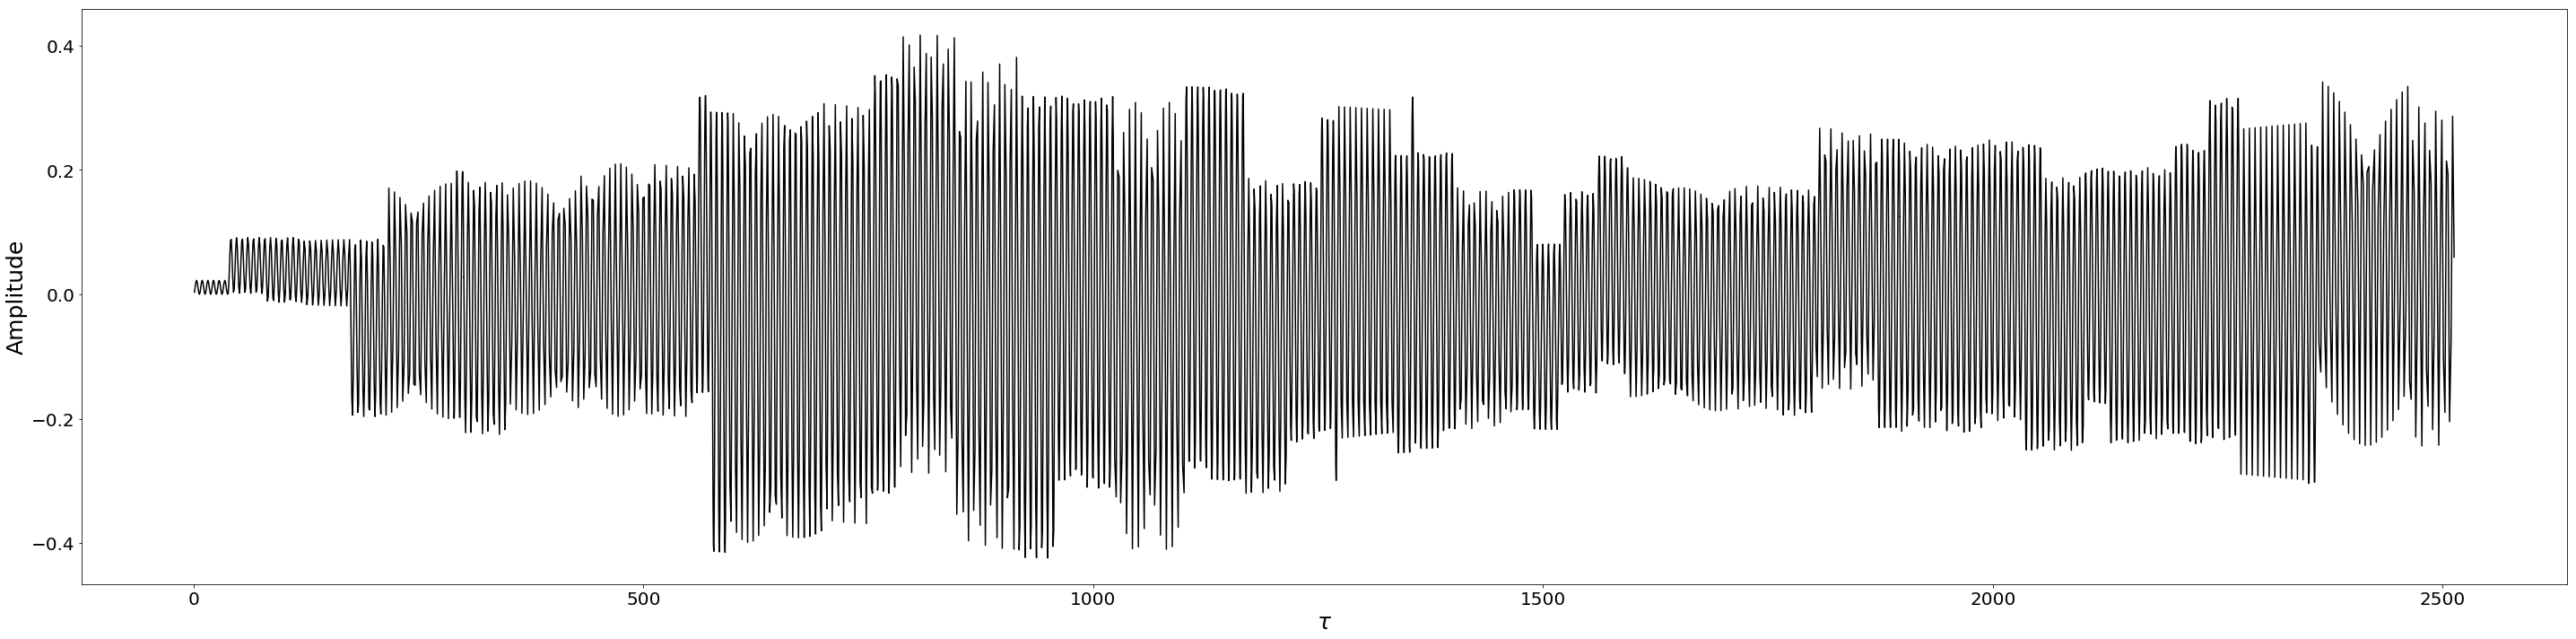

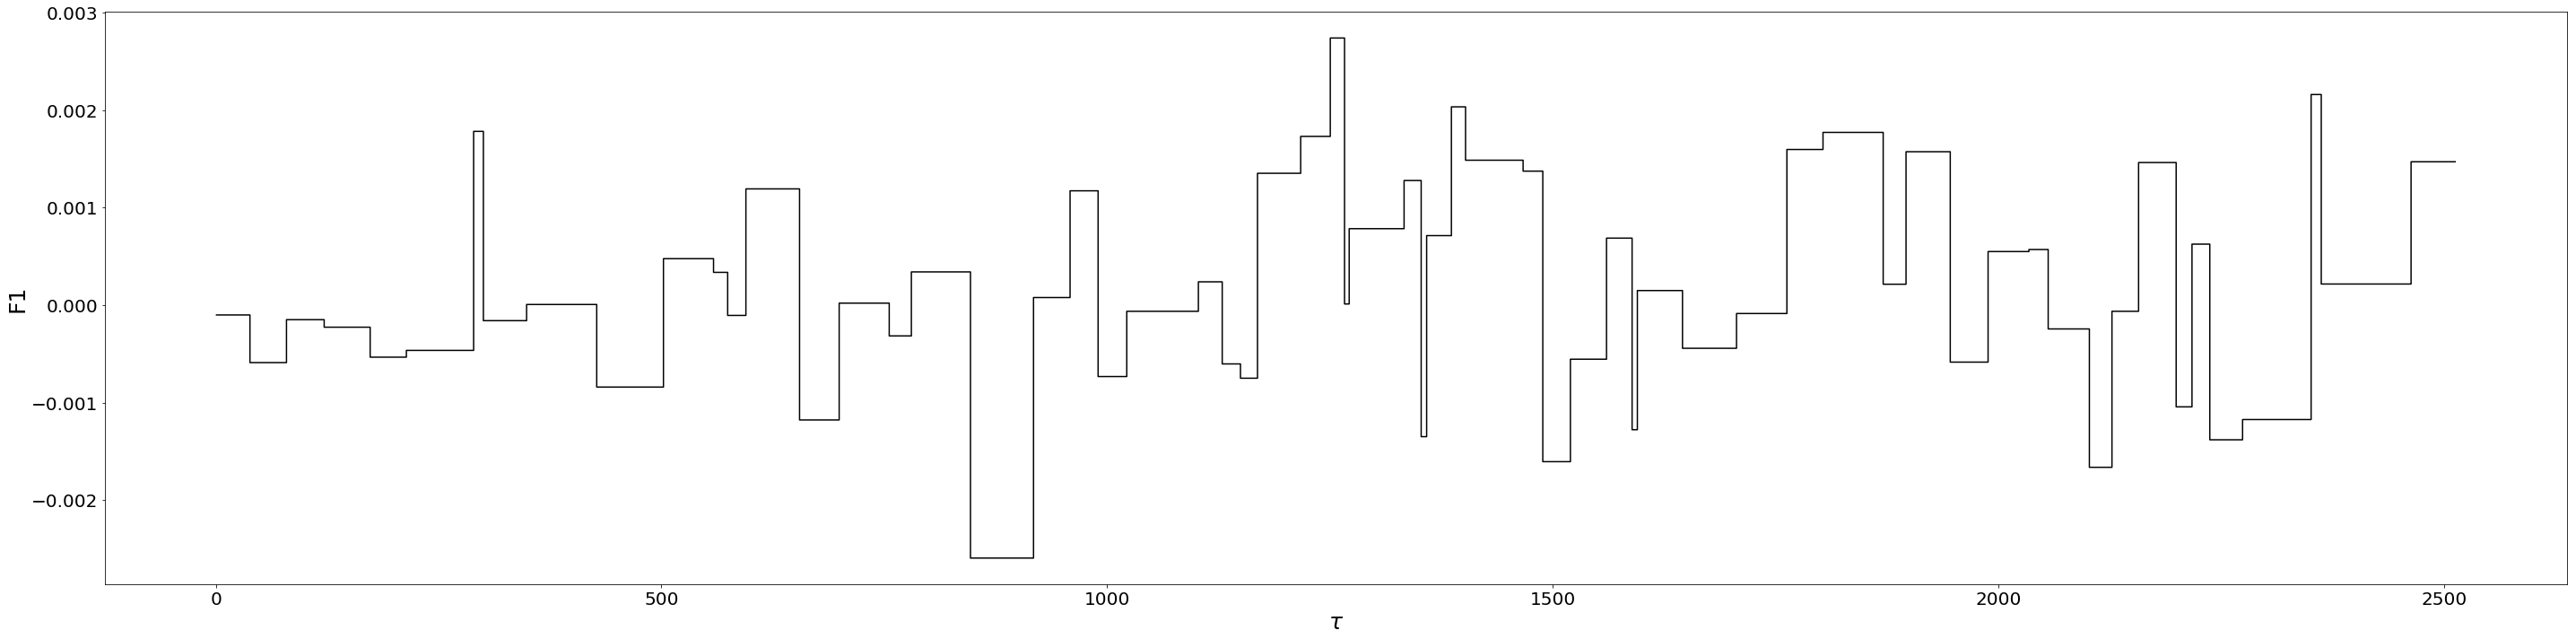

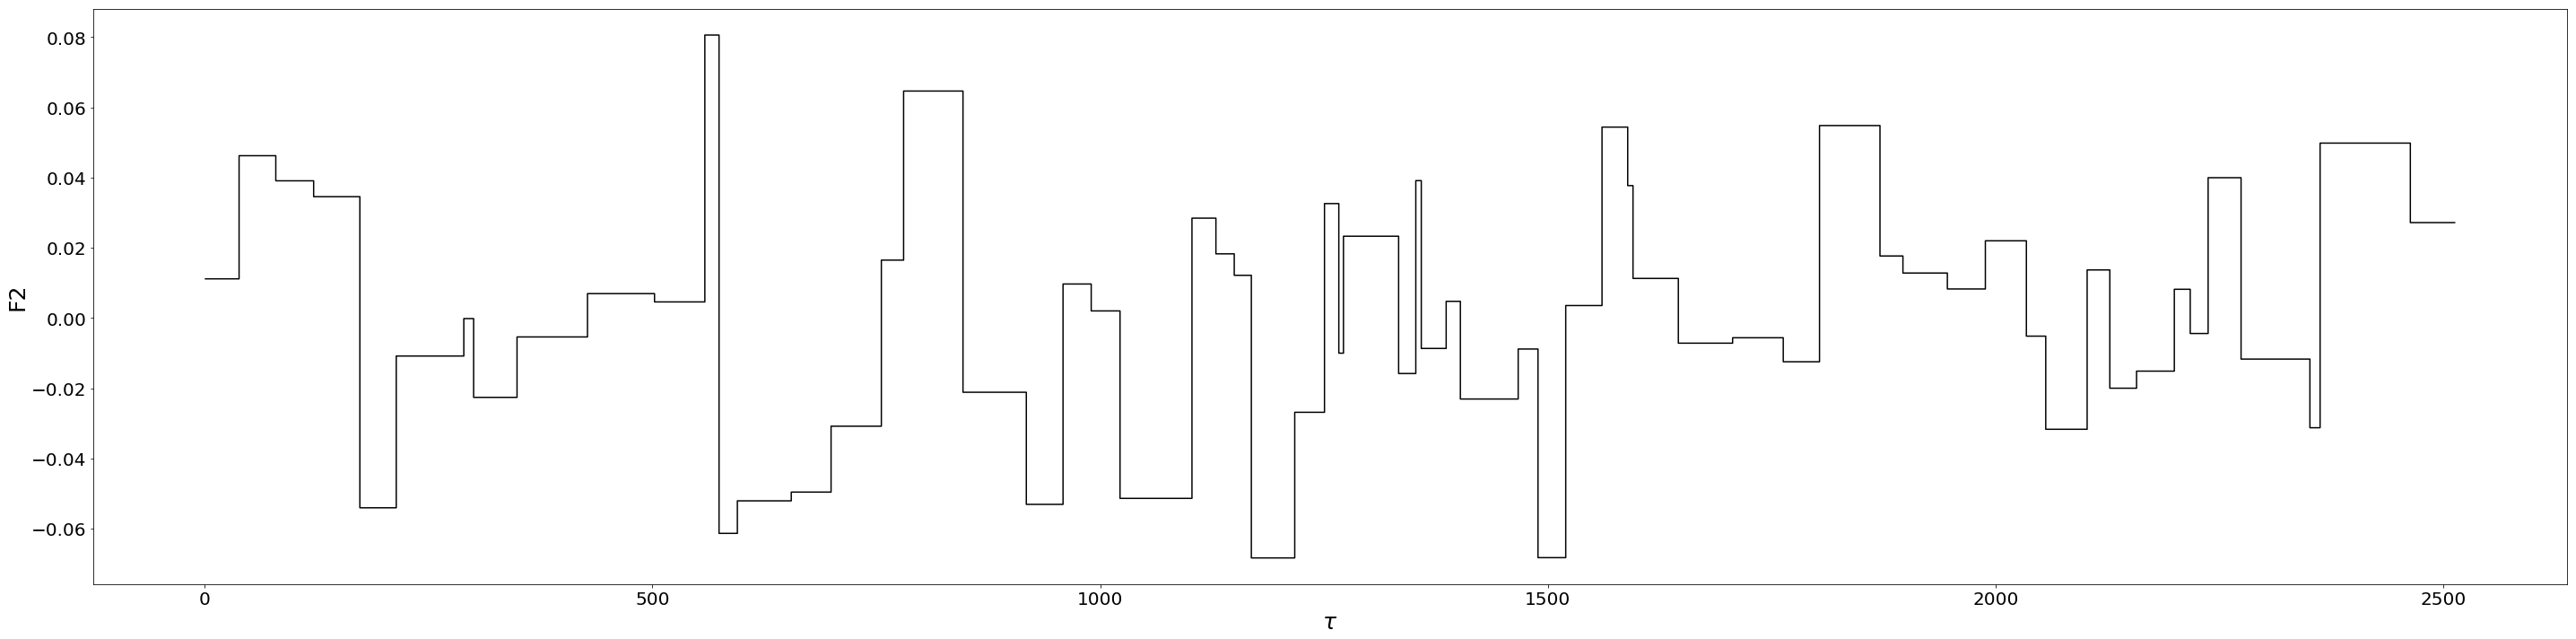

Amplitude of mode for 1800 eddy turnovers
Average of A^2 = 4.917018670461721
median of A^2 = 2.142925608723147
T(max) = 70772.34957096413


In [15]:
plt.figure(figsize=(40,10))
A, t, f1, g1, f2 =funAmp(dAdT, AT)

plt.plot(t, A, 'k')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\tau$', **axis_font)
plt.ylabel('Amplitude', **axis_font)
plt.show()

tshort = []
Ashort = []
f1short = []
f2short = []
index = 0
# M = 400
while t[index] < 2*np.pi*400:
    tshort.append(t[index])
    Ashort.append(A[index])
    f1short.append(f1[index])
    f2short.append(f2[index])
    index +=1

Funplots(tshort, Ashort, f1short, f2short)

Asqr = FunAsqr(A)
avg = sum(Asqr) / len(Asqr)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("Average of A^2 =", avg)
print("median of A^2 =", statistics.median(Asqr))

# T(max) is the duration of each evolution
Tmax = t[-1]
# want T(max) ~ 2*pi*10^4
# T(max) = 2*pi*M
print("T(max) =", Tmax)

## Amplification Distribution Function

In [16]:
delA = 0.005

delt = N * deltaT

In [17]:
def funAlpha(A, t, alpha):

    # root mean square of amplitude for T(max)
    Abar_max = FunRMS(A)

    # the number of time segments is the total time (Tmax)/delT
    numsegments = int(Tmax/int(sum(delt)/len(delt)))+1

    # 2d array containing an array for amplitudes in each segments
    ampsegments = []

    # this loop divides the total duration T(max) into equal segments of delT
    # and adds corresponding amplitudes in each time segment to amsegments 
    i=0
    for count in range(0, numsegments):
        # amp segment contains the amplitudes in the specified time segment
        ampsegment = []
        # checks if that time is withint the correct time segment
        while i < len(t)-1:
            if (t[i] < (count+1)*2*np.pi):
                # adds the corresponding amplitude if the time is within specified time segment
                ampsegment.append(A[i])
                i+=1
            else:
                # breaks the while loop if the time is outside the time segment 
                # and moves to the next time segment
                break        
        ampsegments.append(ampsegment)


    # take Abar(T) = rms(A in delT)
    # Abar is the root mean square (RMS) of A in delT   
    Abar = []    
    for ampsegment in ampsegments:
        Abar.append(FunRMS(ampsegment))

    # in order to better exhibit the distribution of the full range of values of Abar, use instead
    # alpha = log(Abar) so -4 <= alpha <= 0
    tempalpha = FunLog(Abar)
    alpha.append(tempalpha)

    alpha_max = max(tempalpha)
    alpha_min = min(tempalpha)
    
    return alpha

def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

evolution 1 above
evolution  2


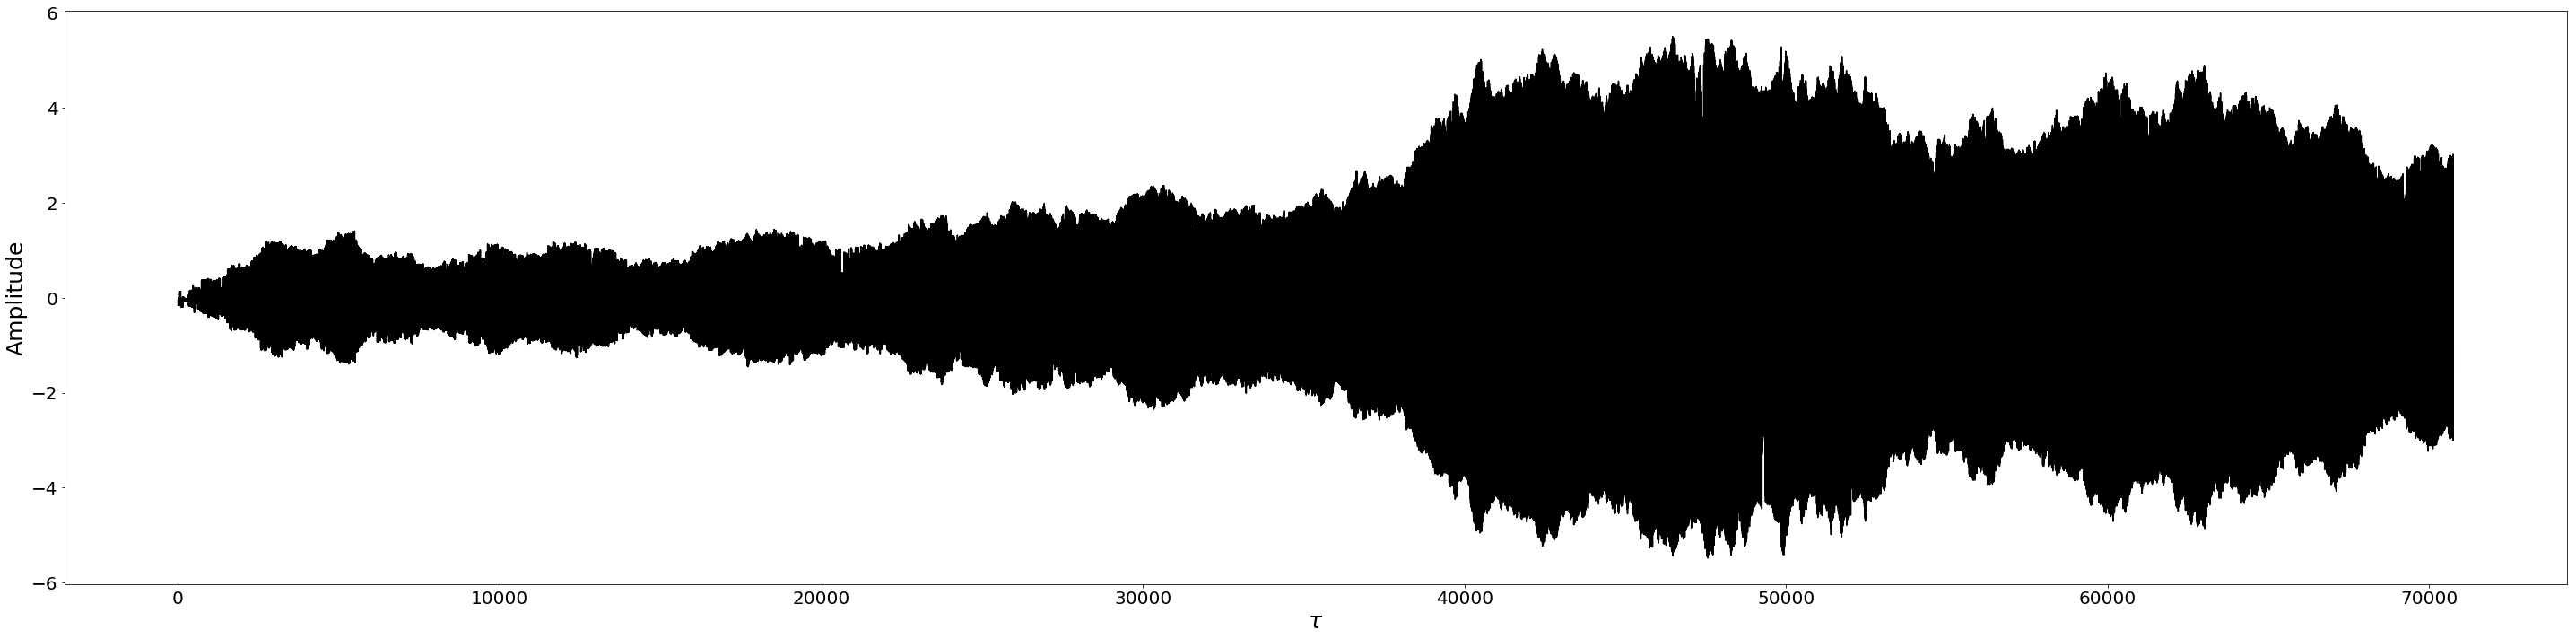

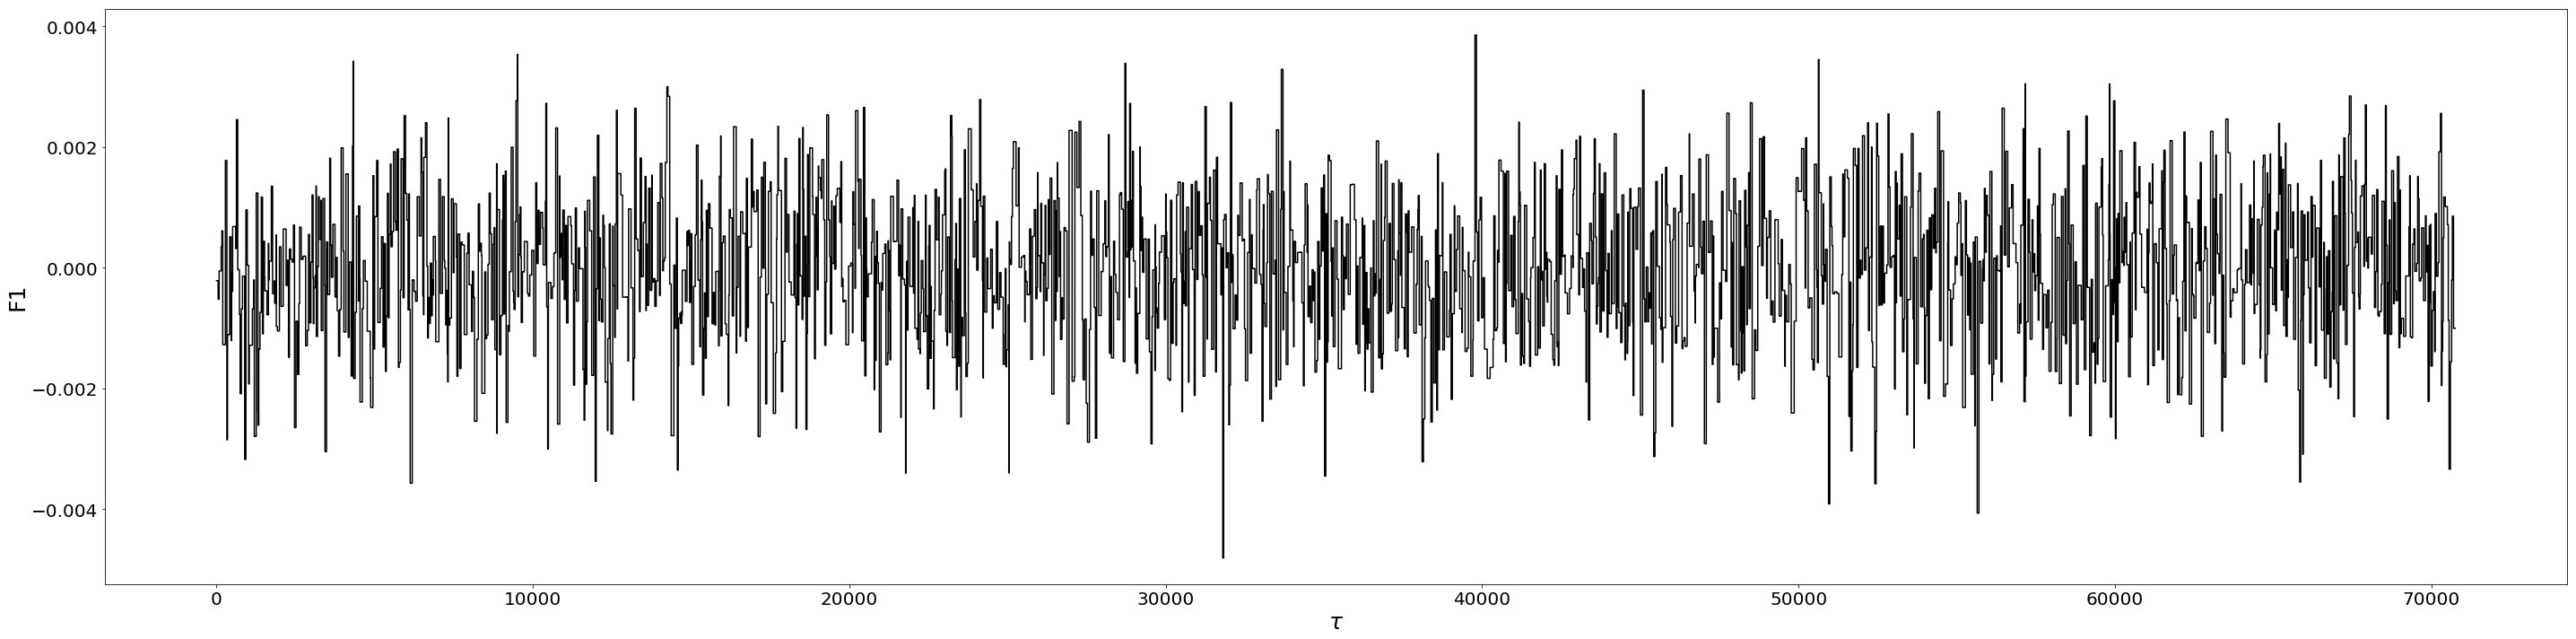

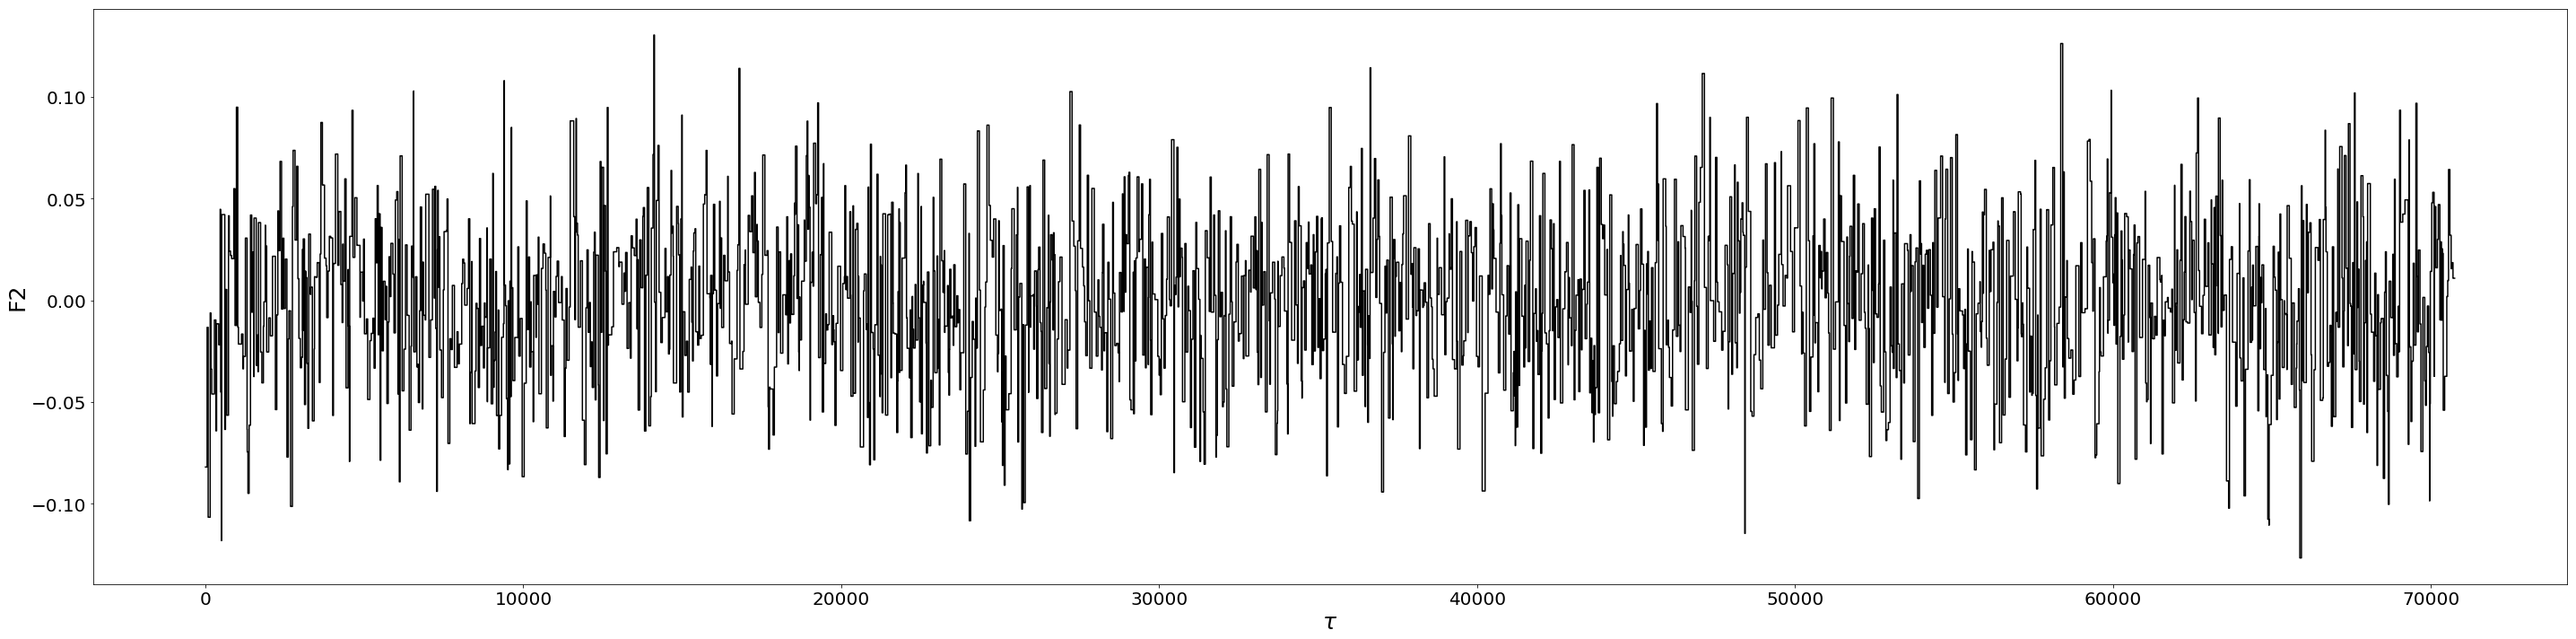



evolution  3


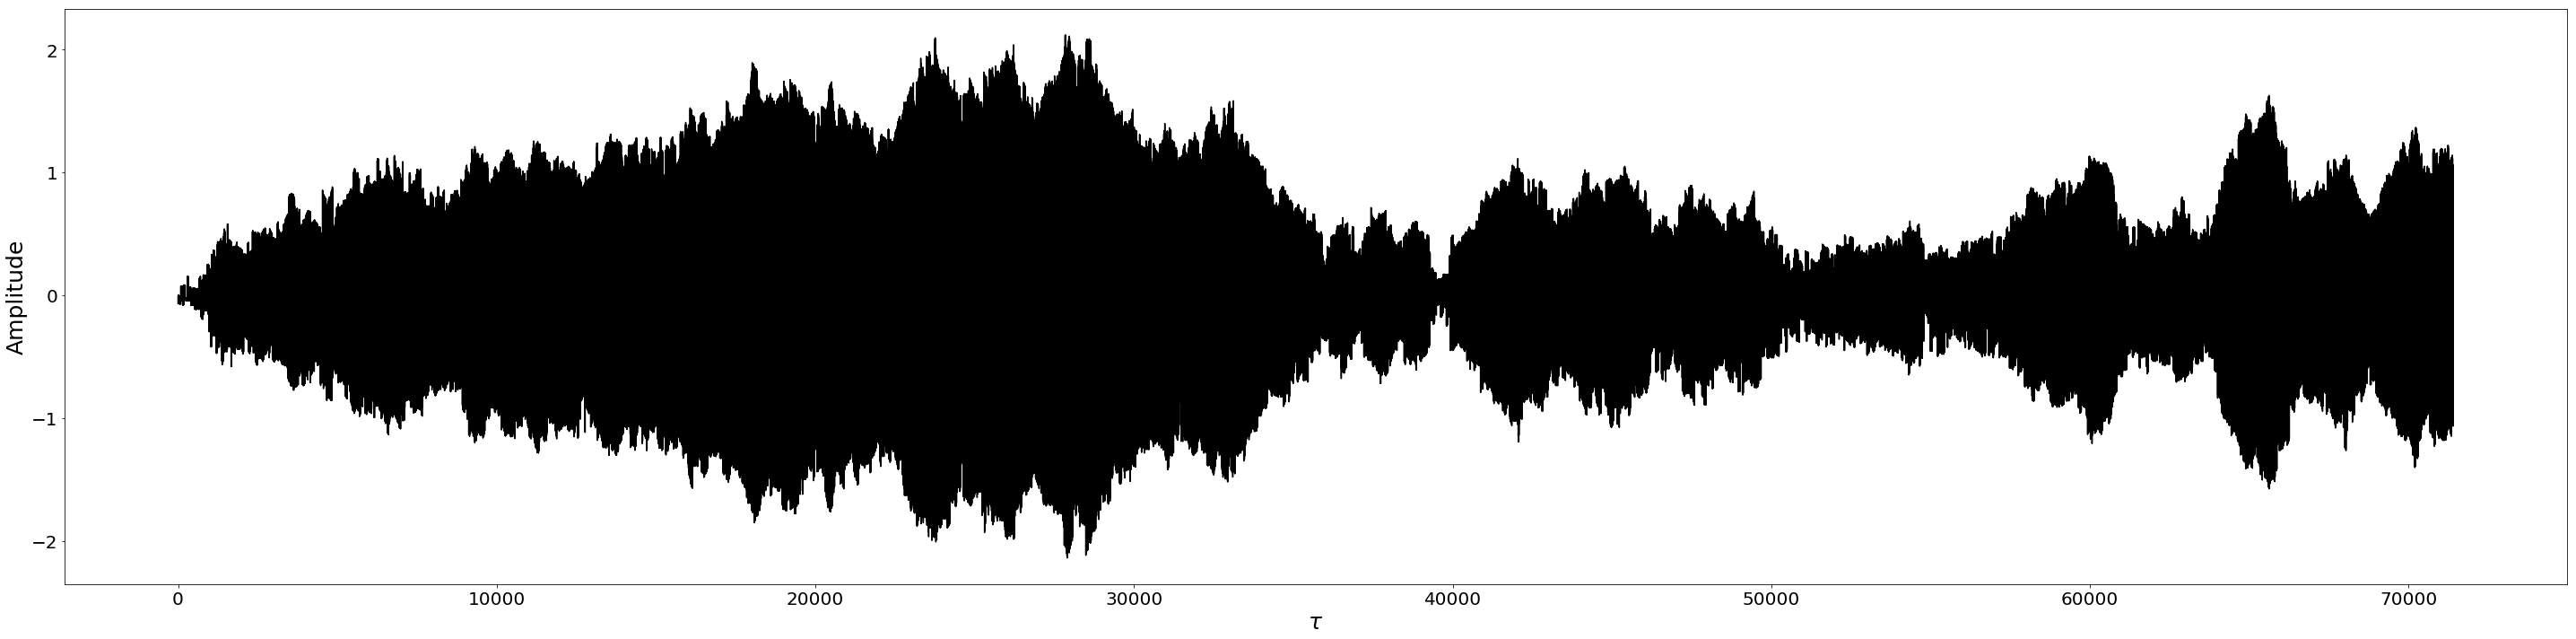

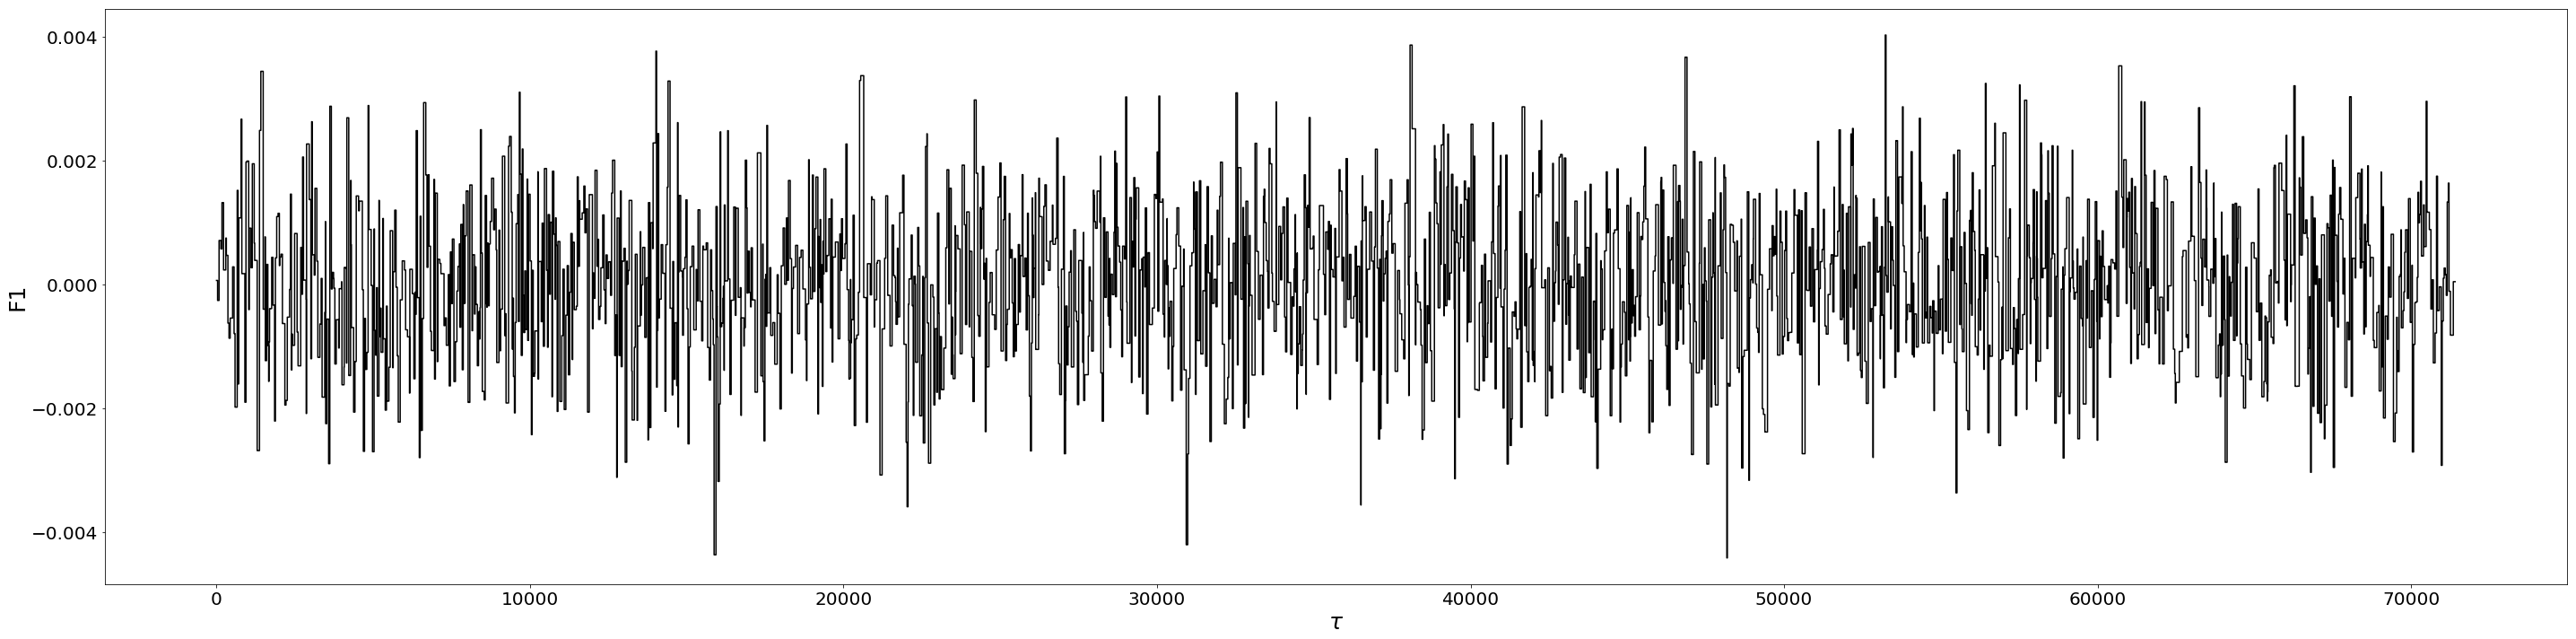

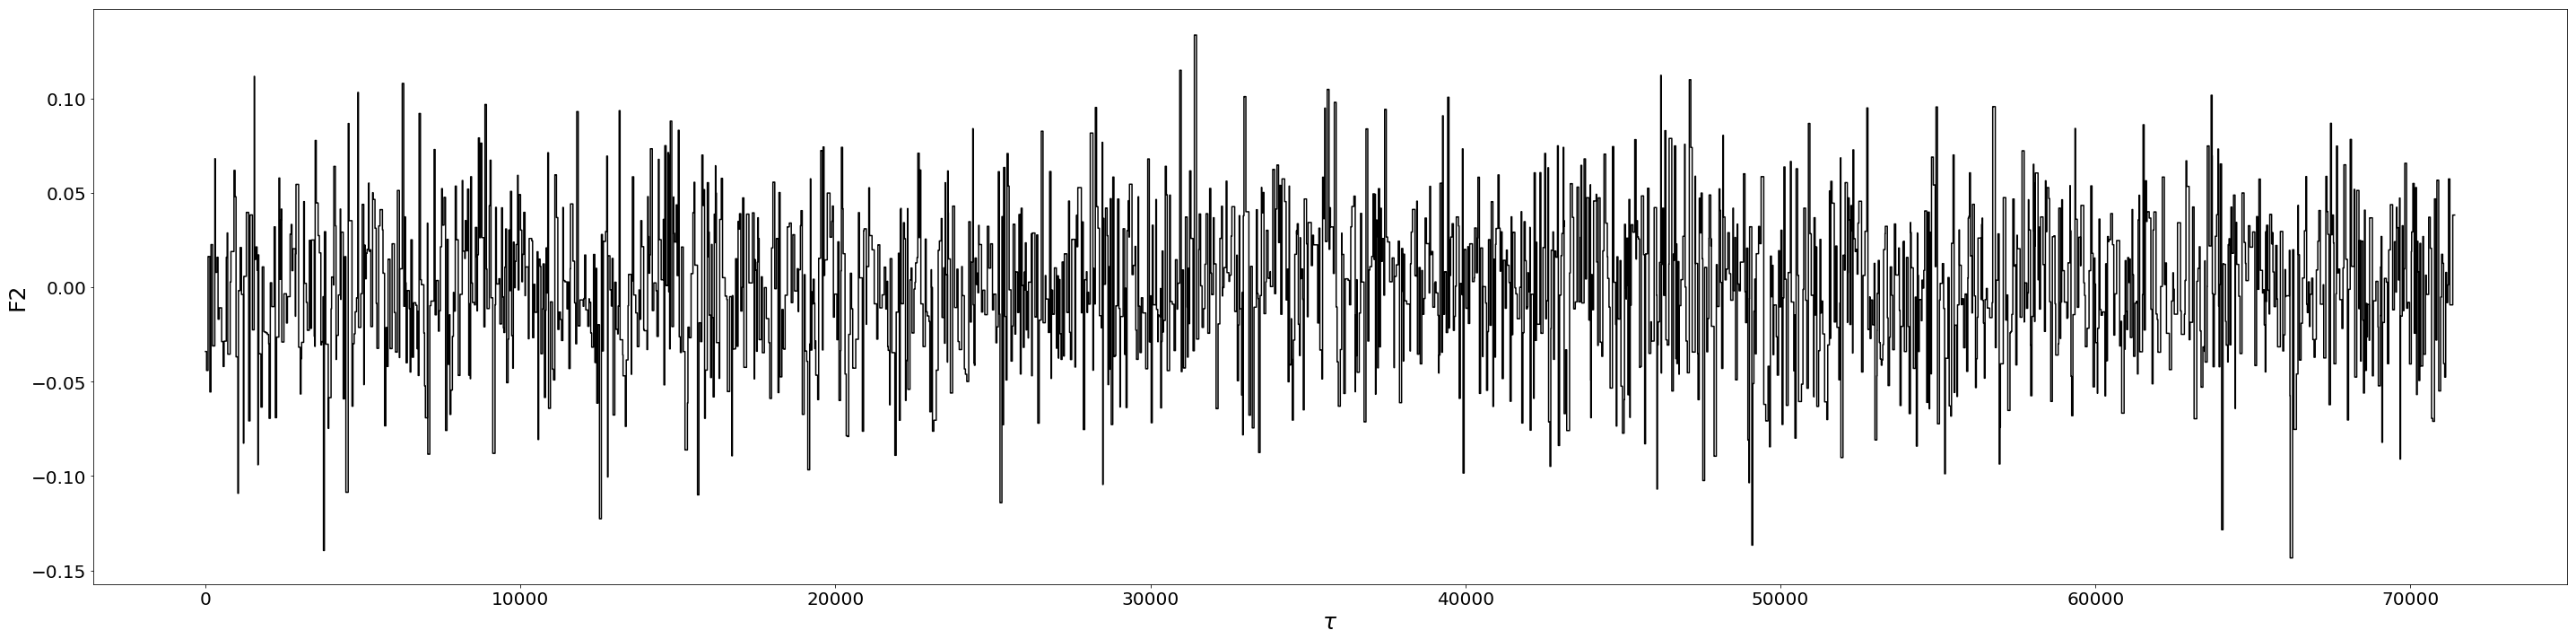



evolution  4


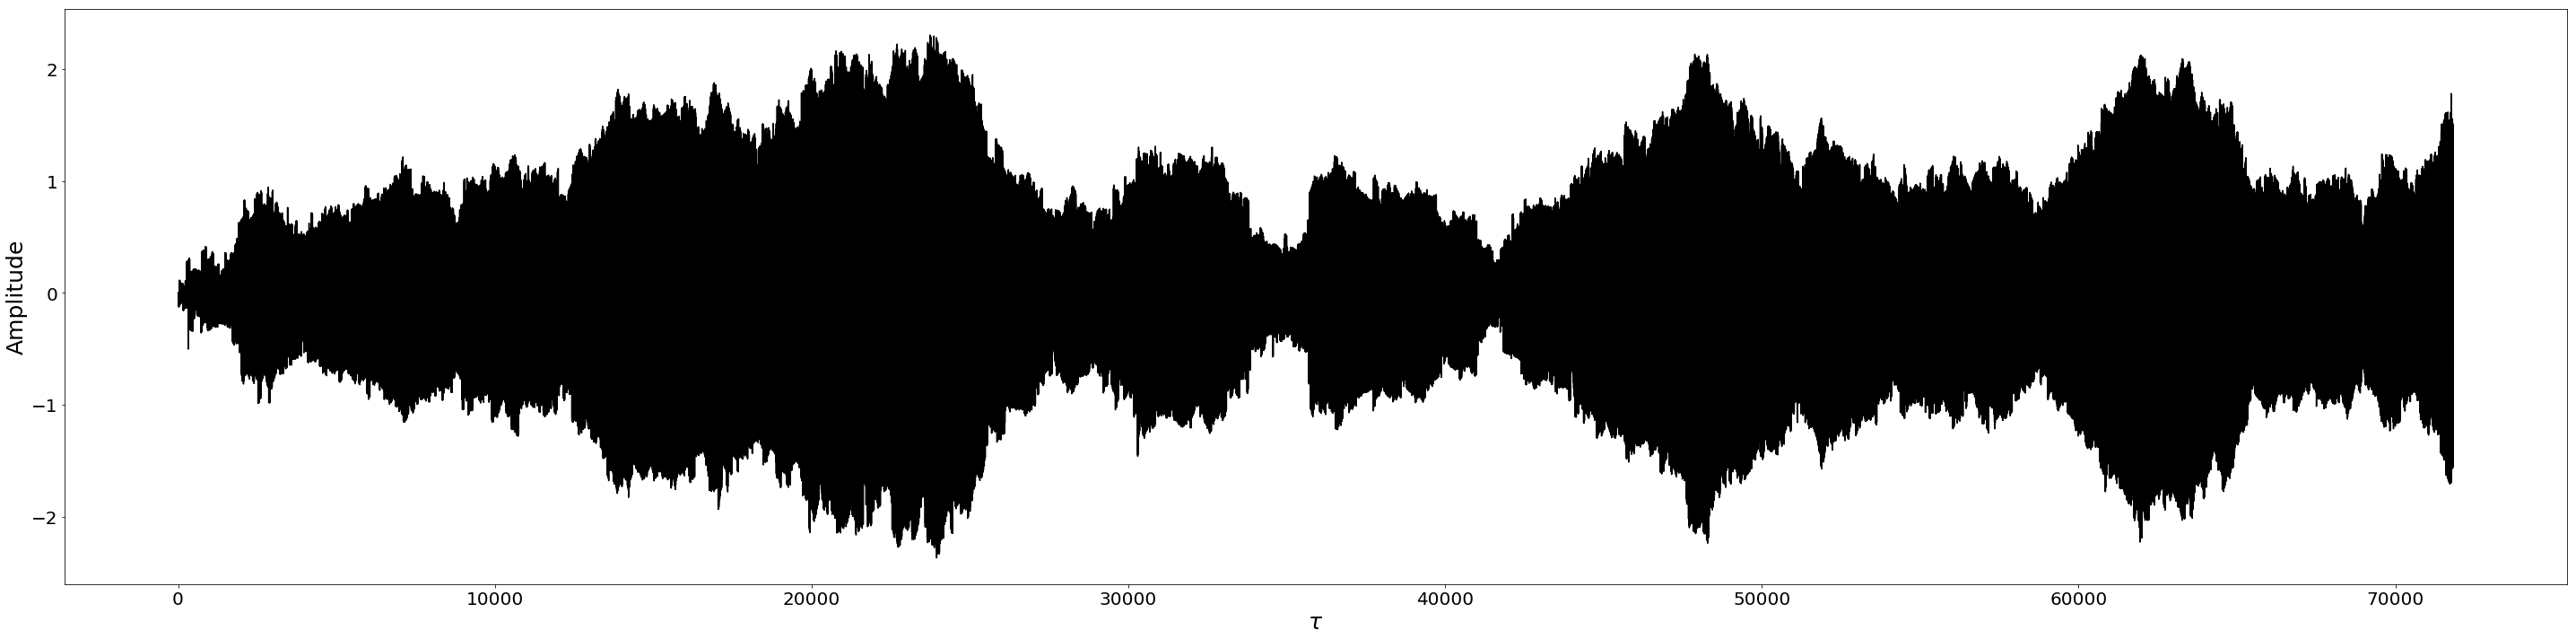

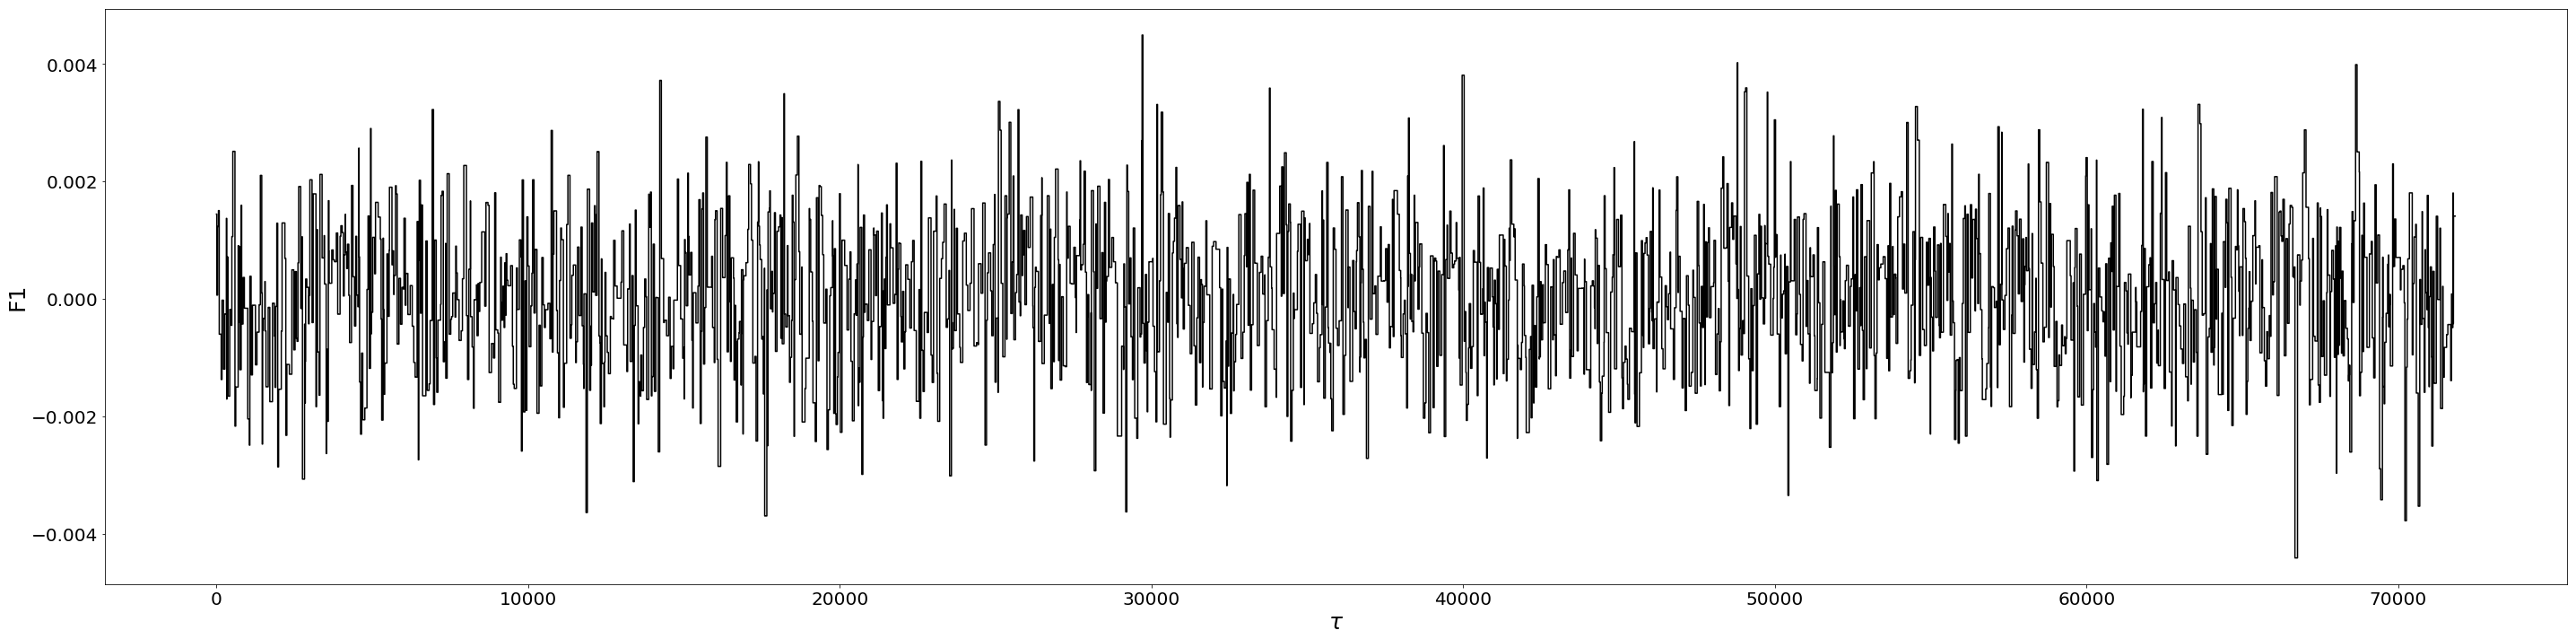

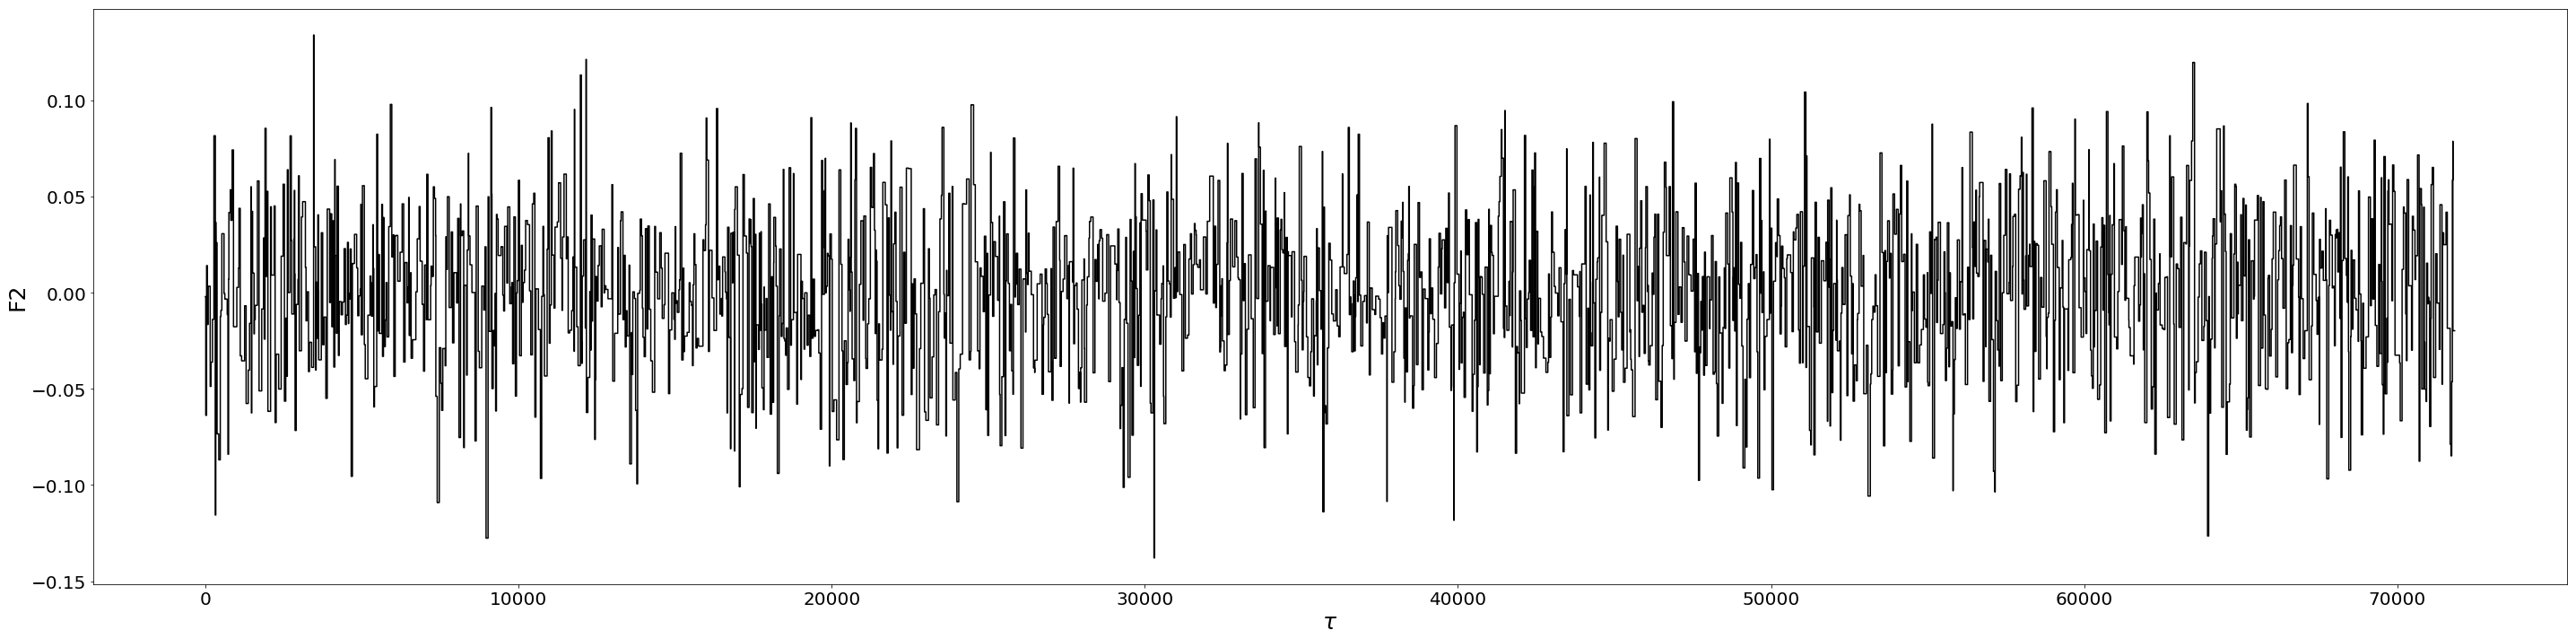



evolution  5


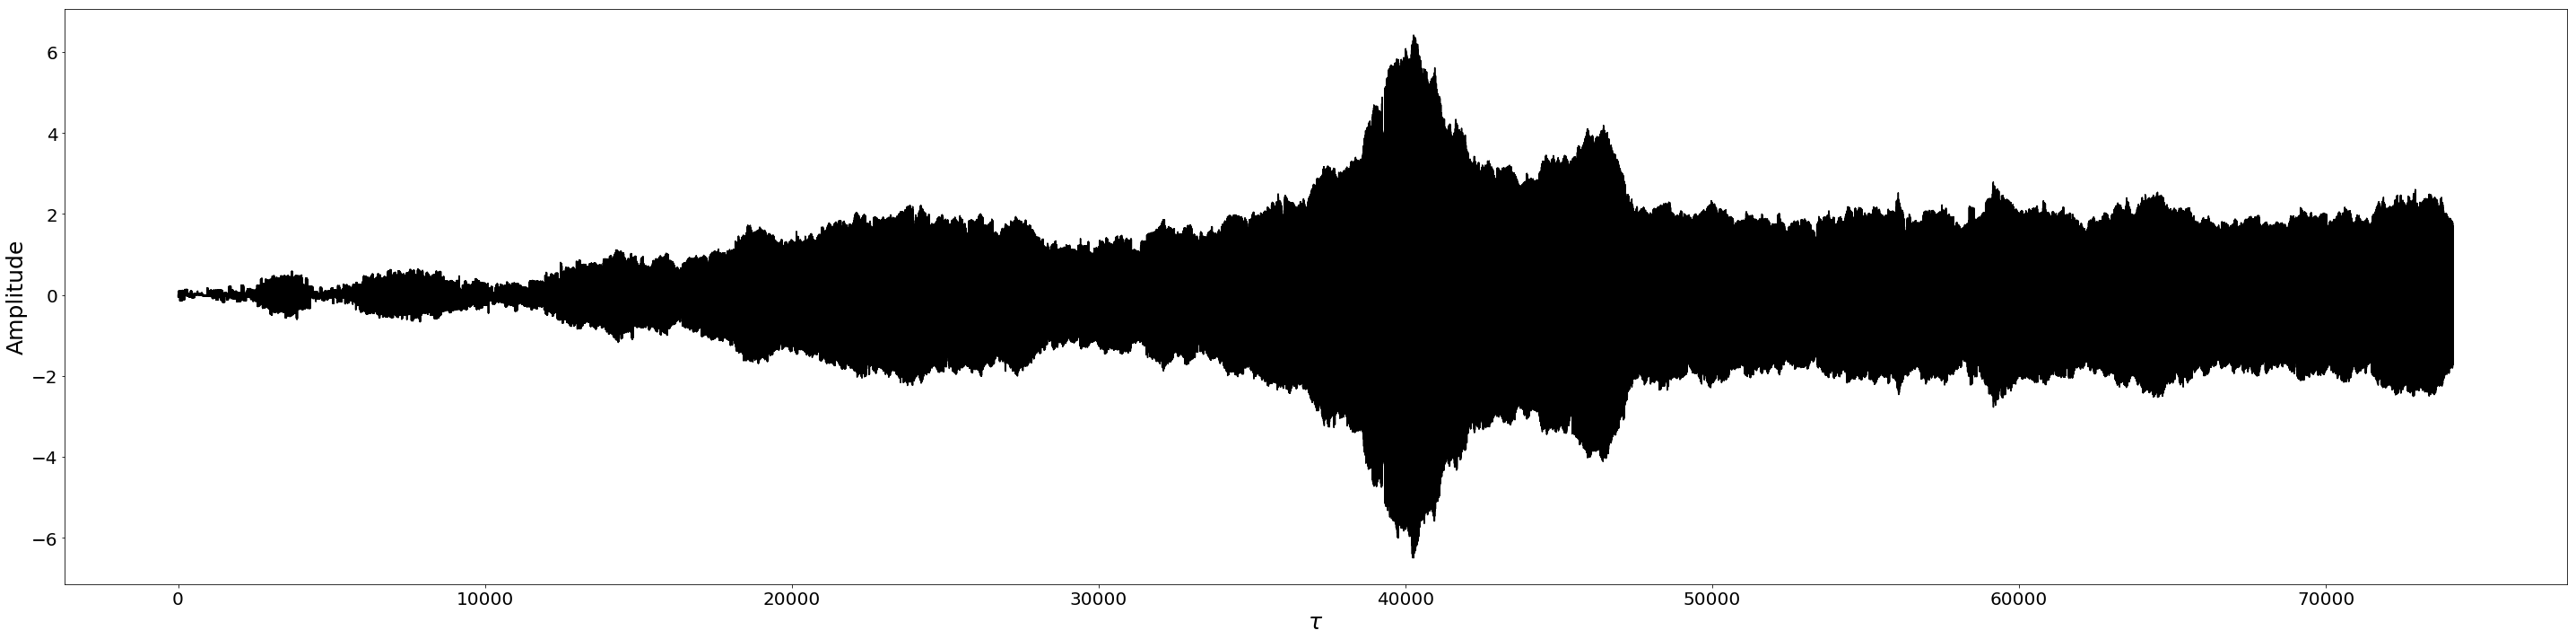

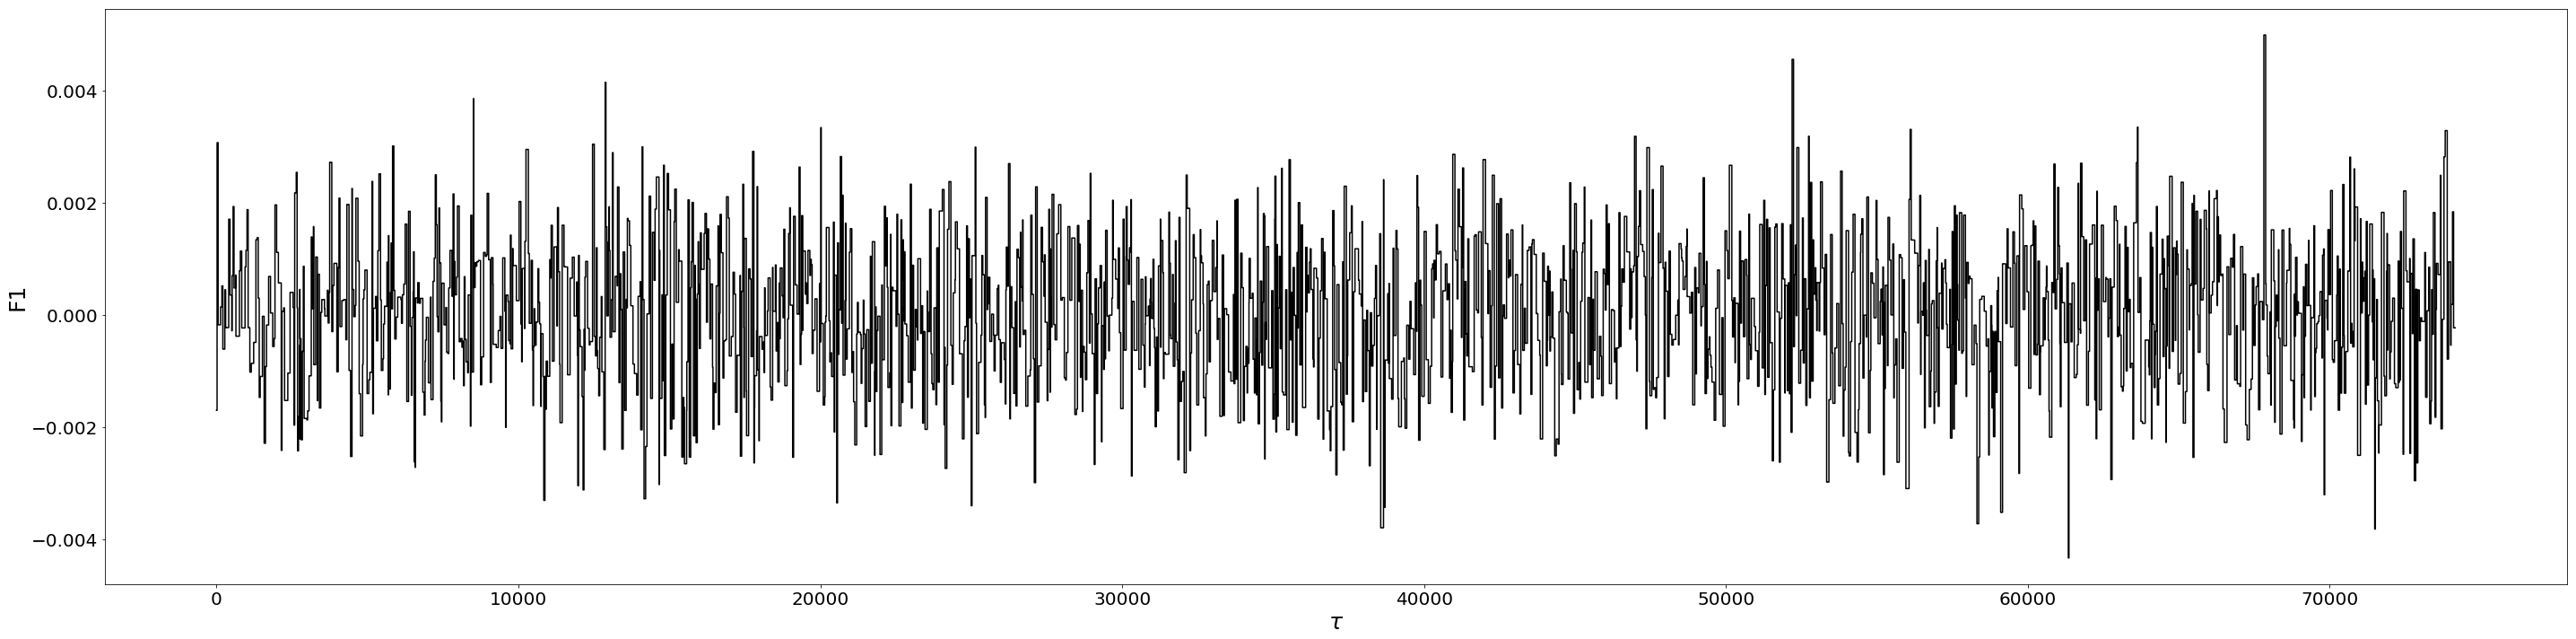

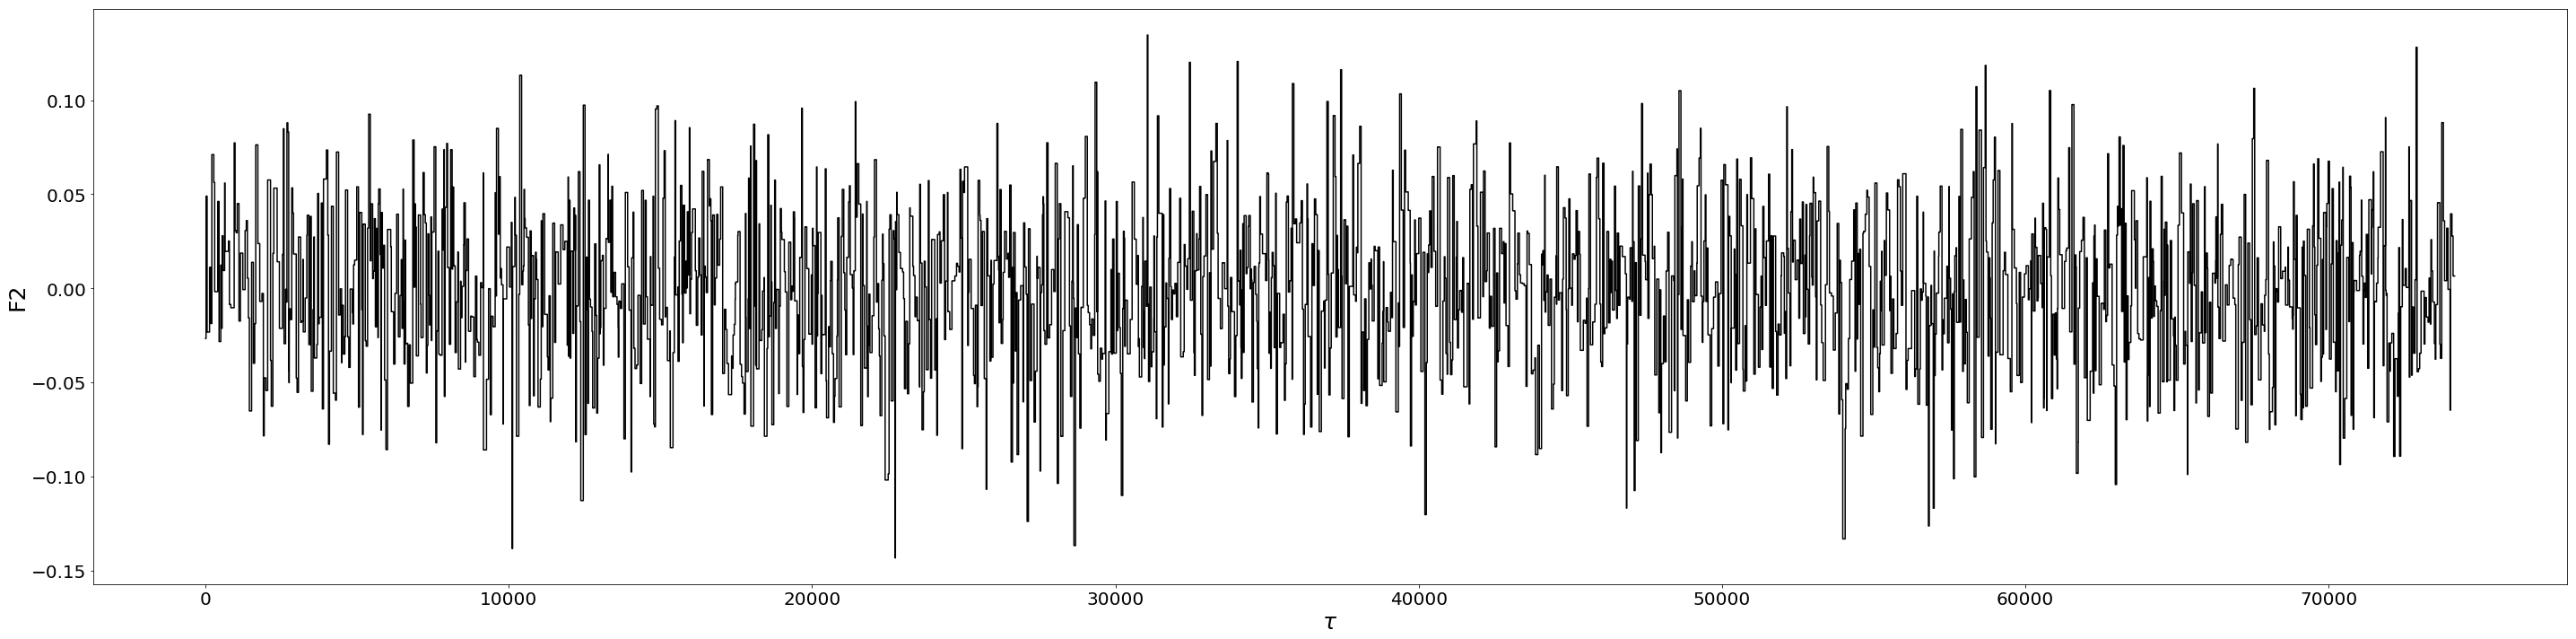



evolution  6


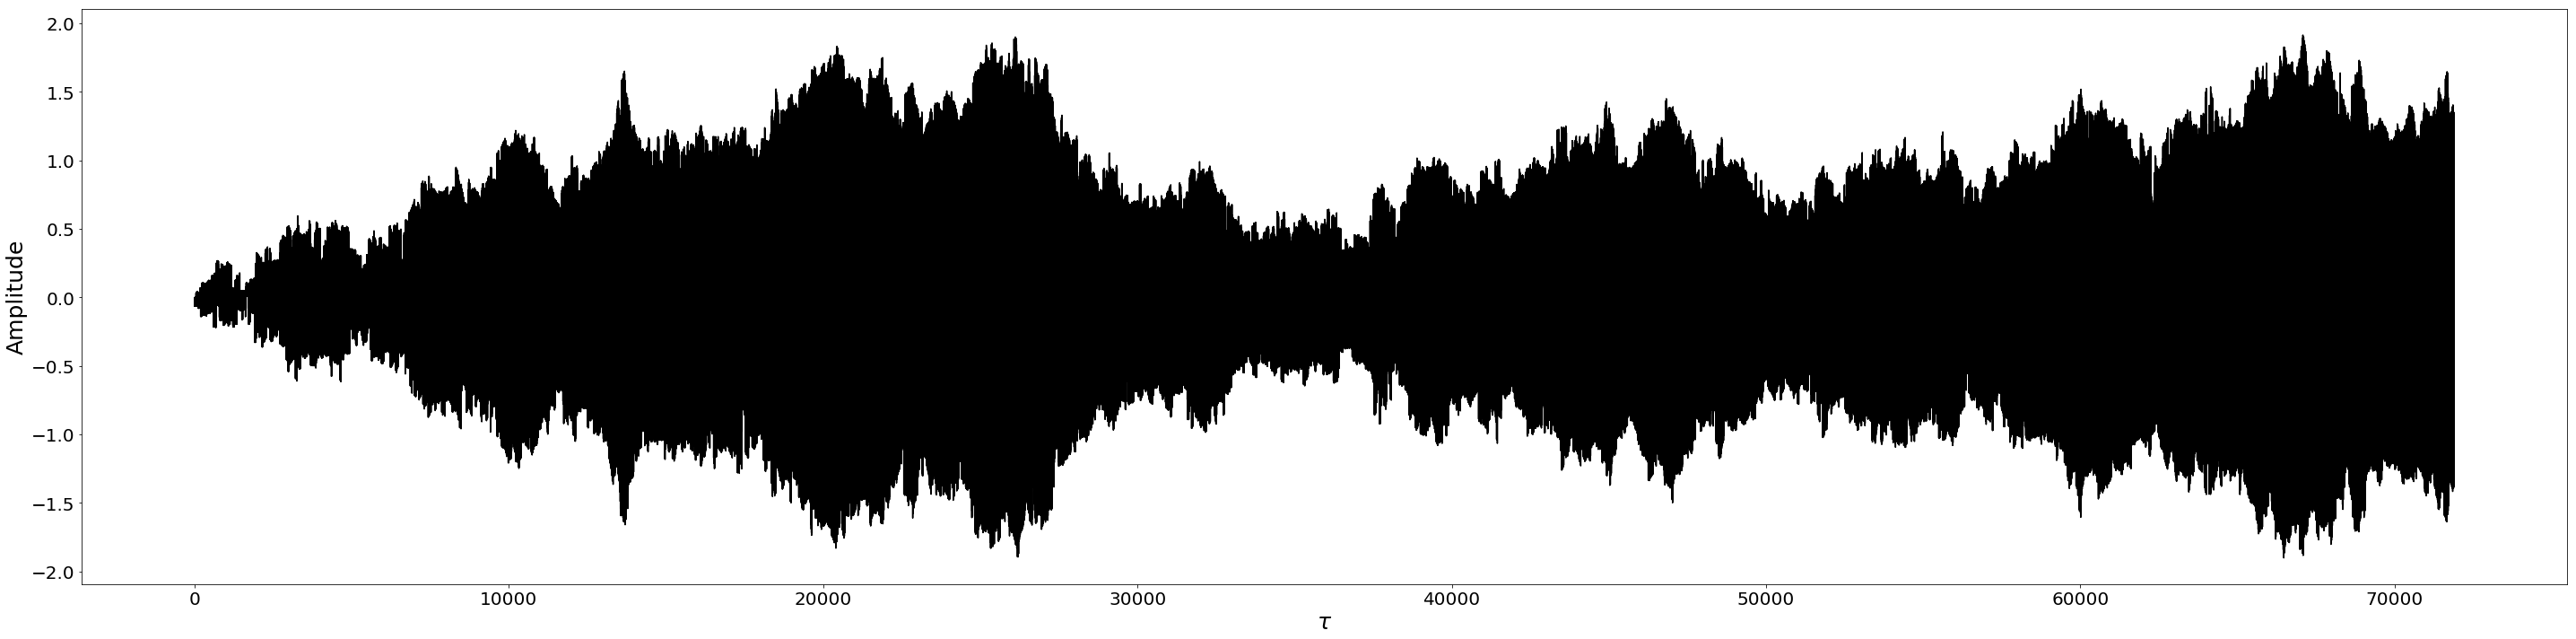

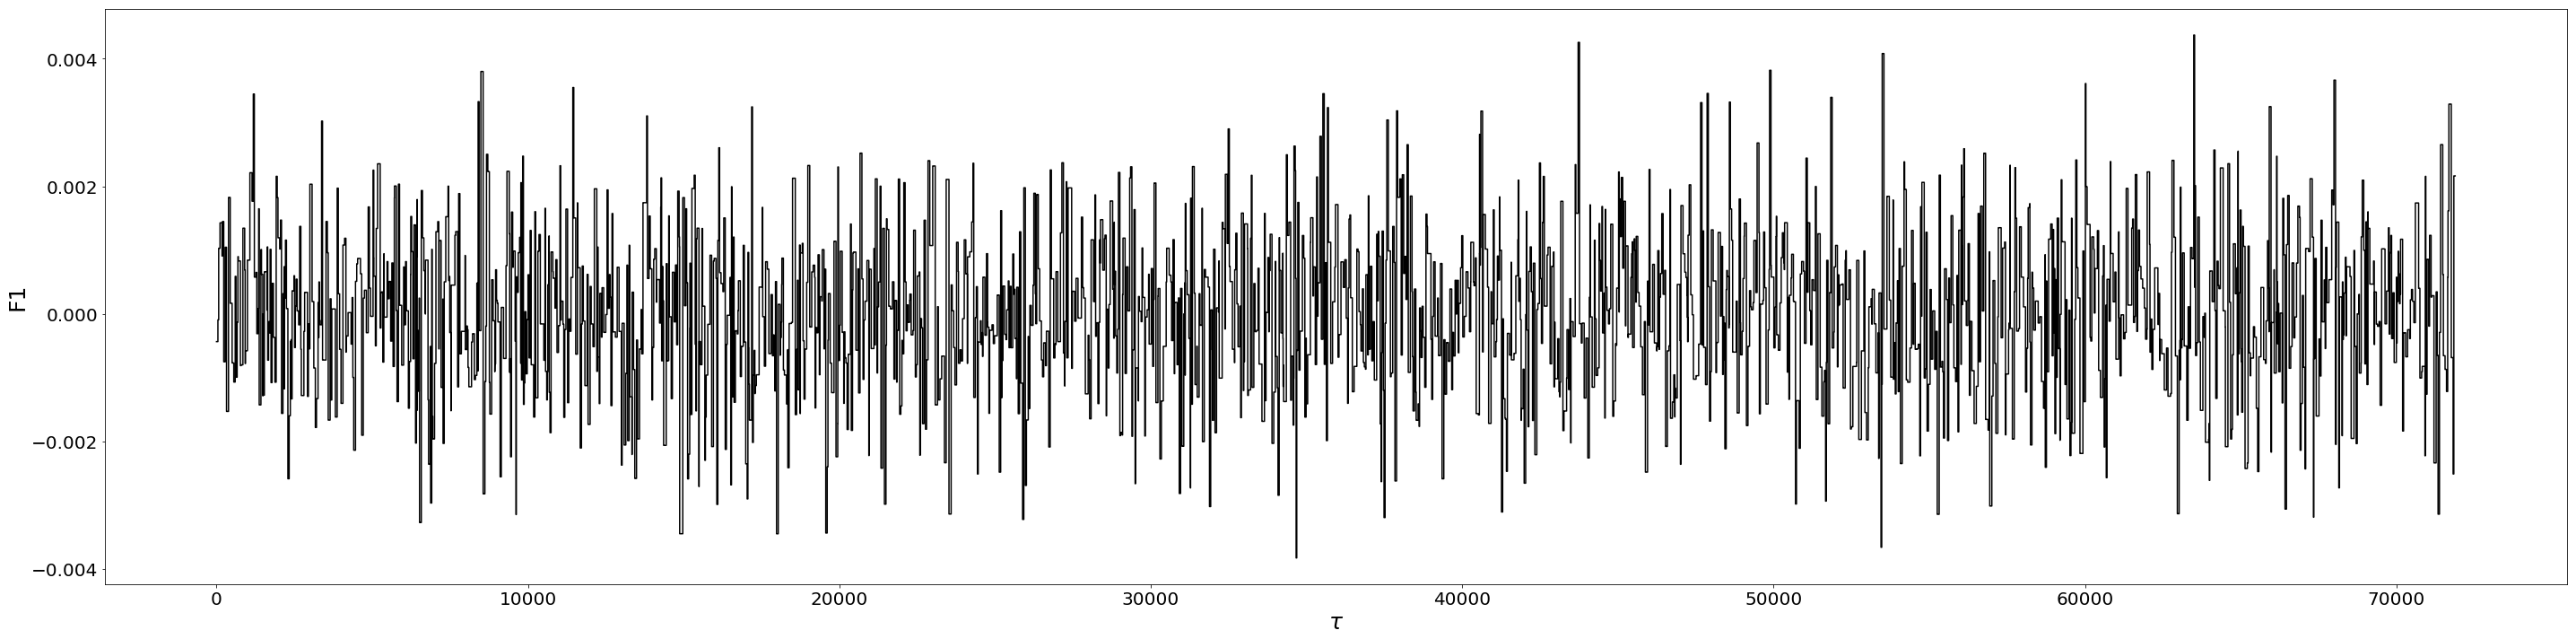

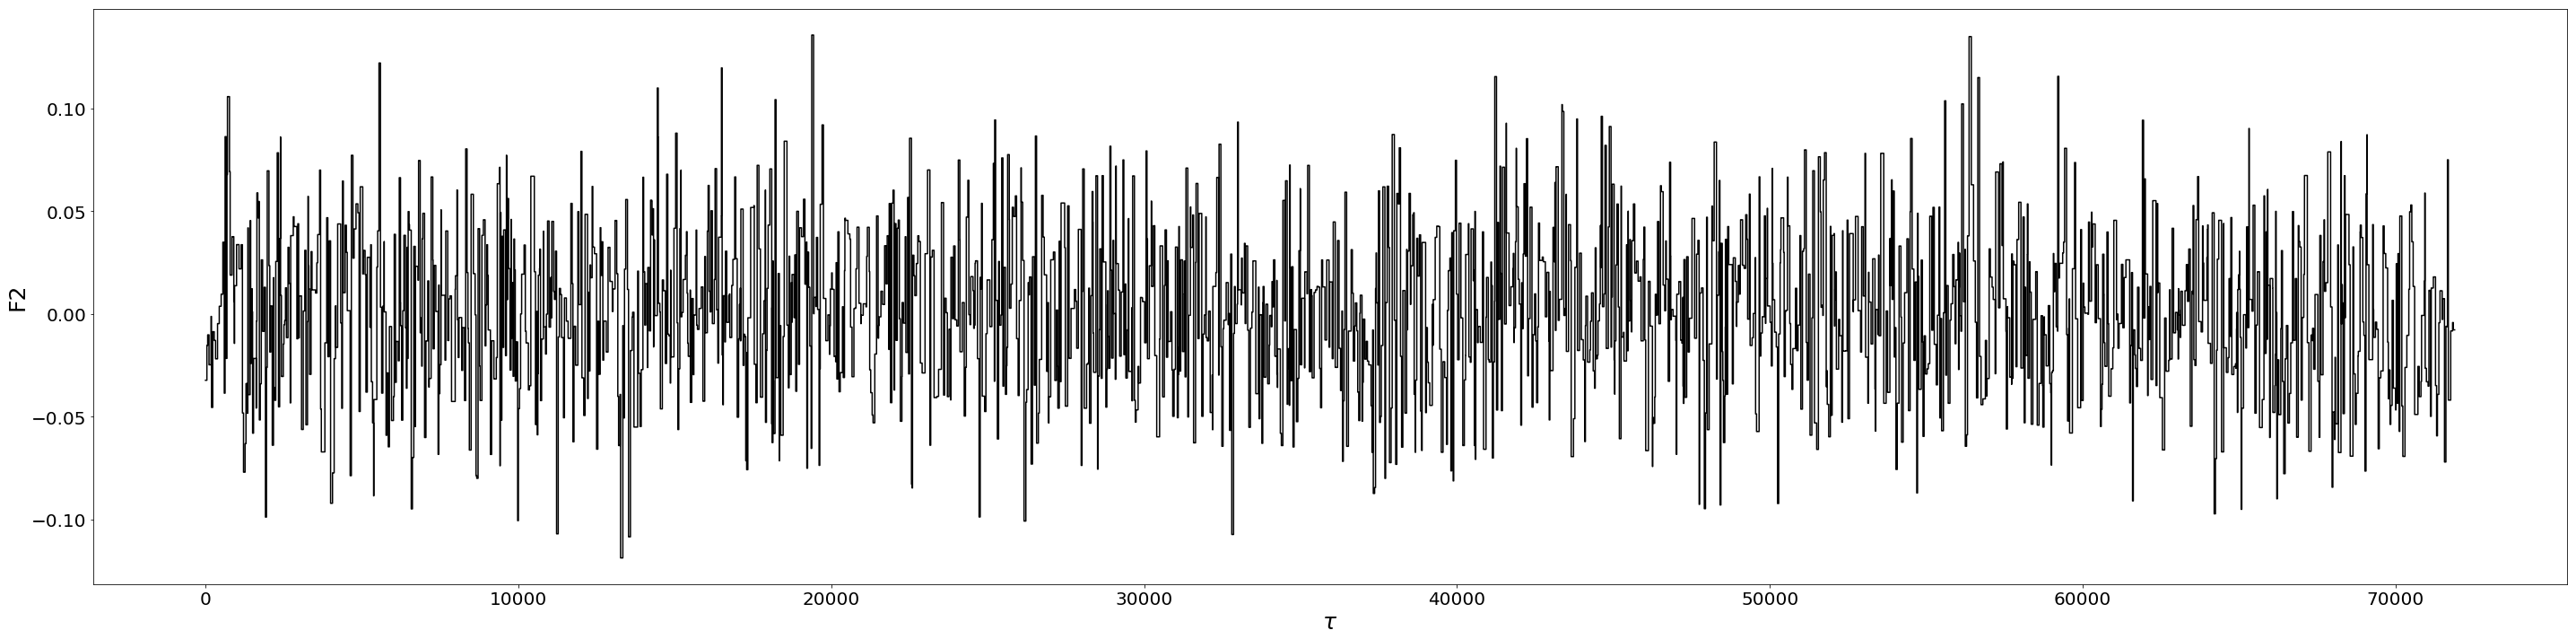



evolution  7


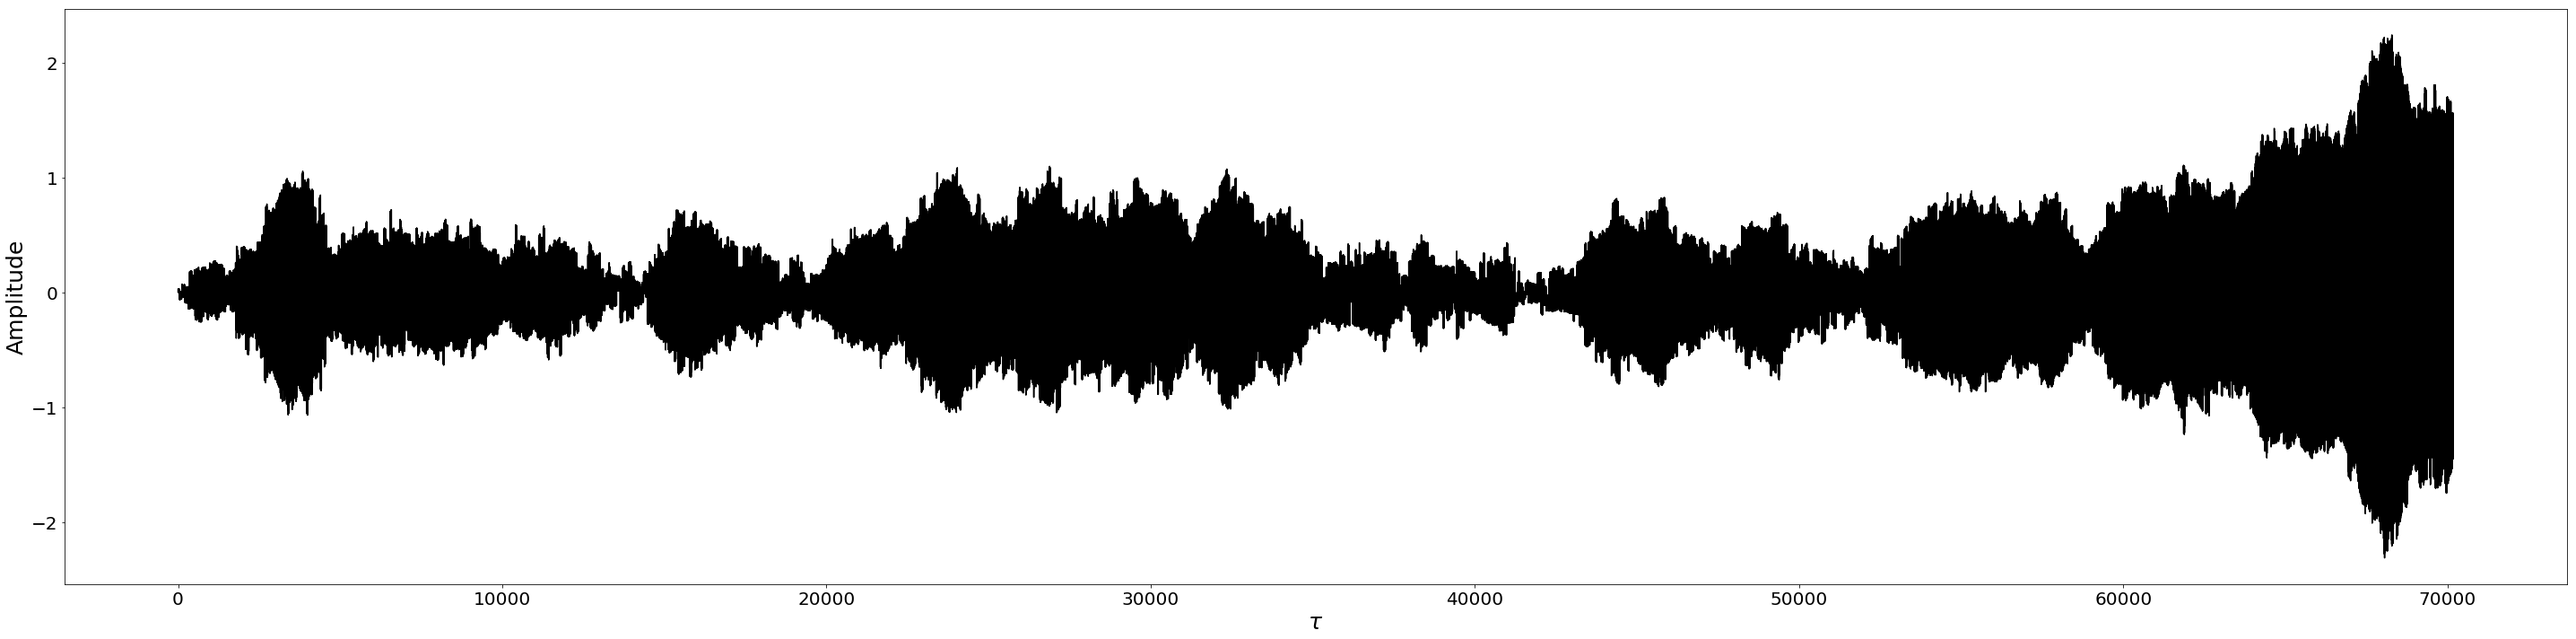

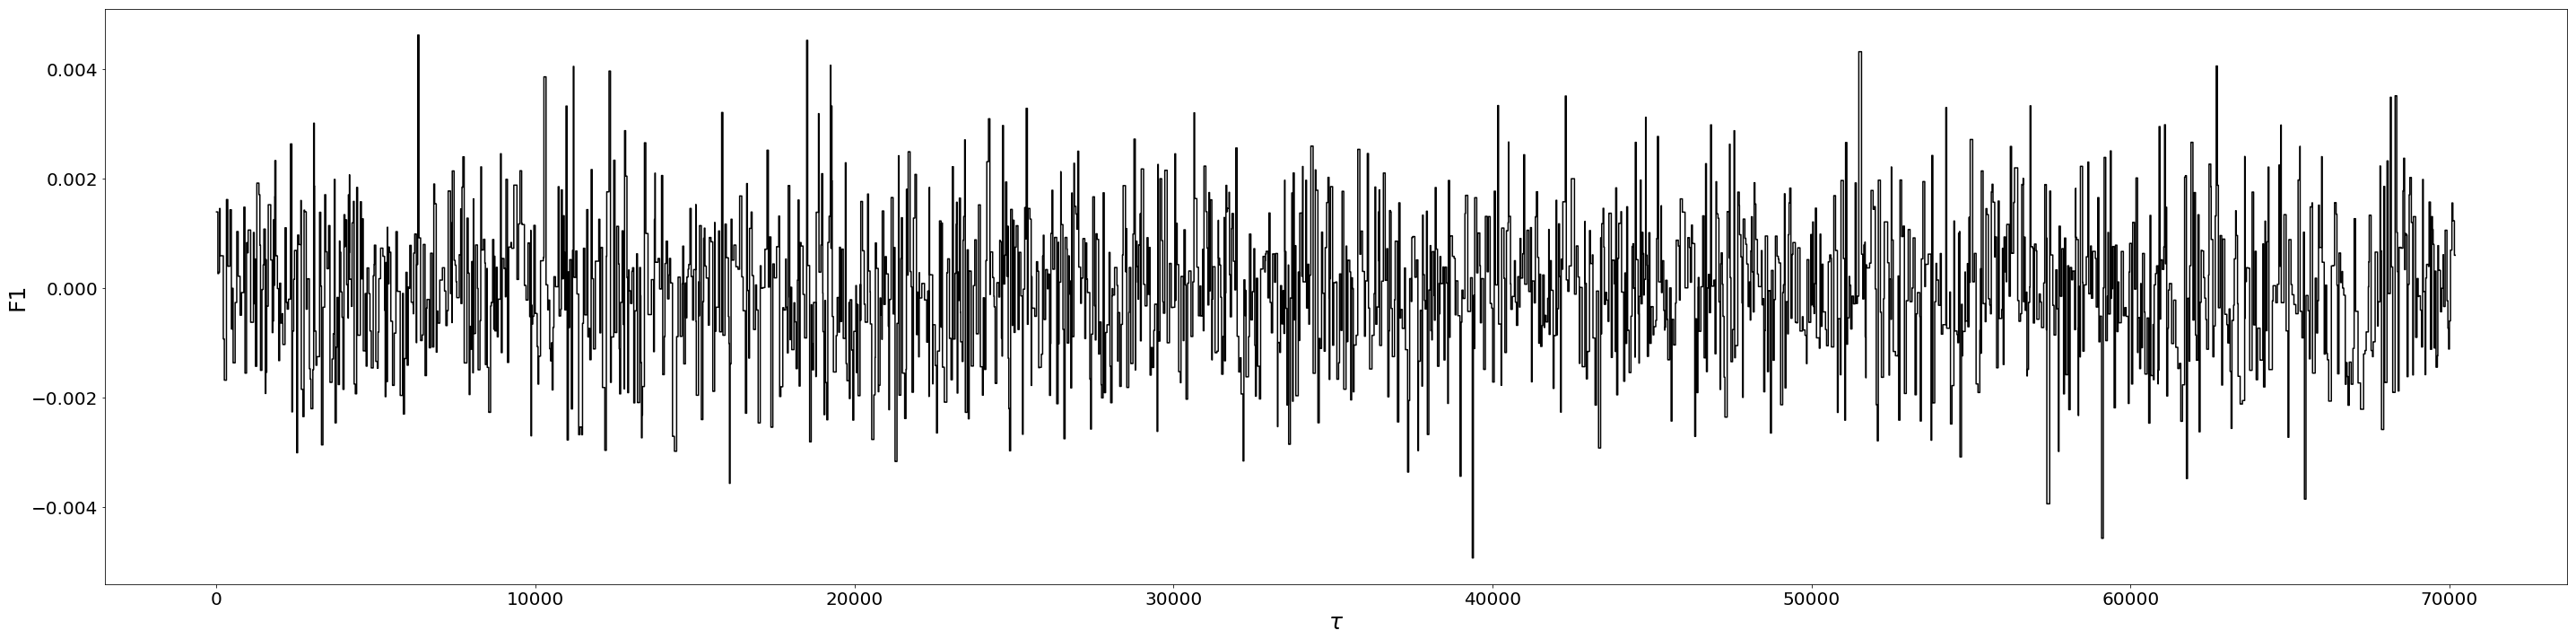

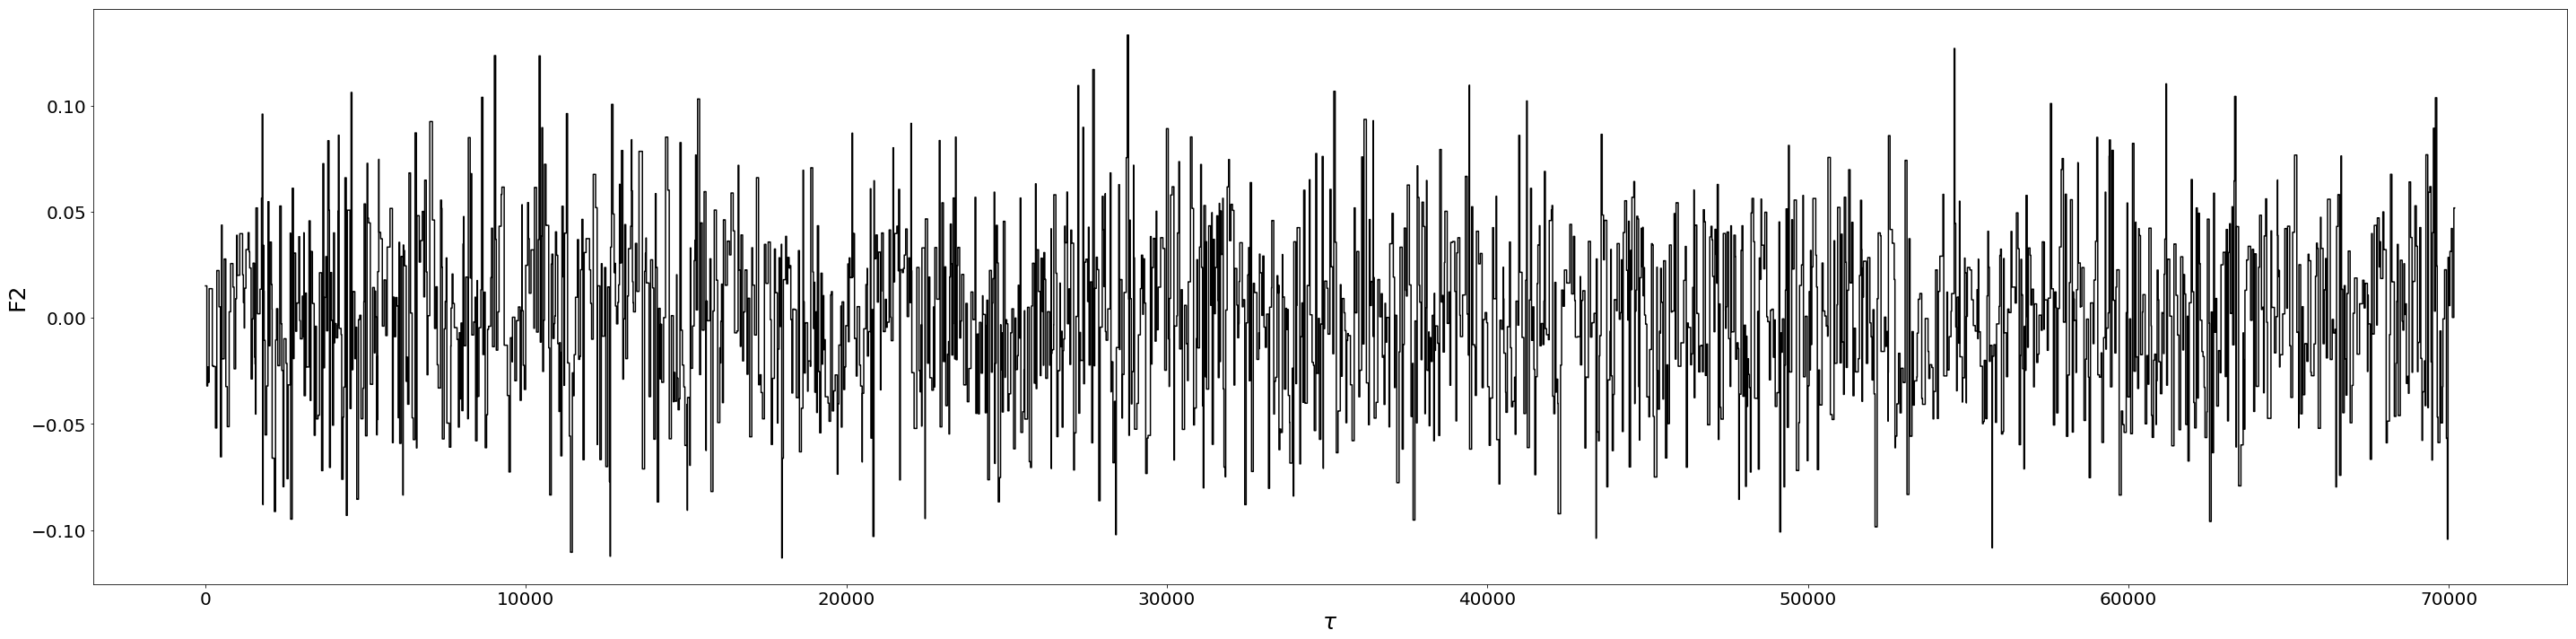



evolution  8


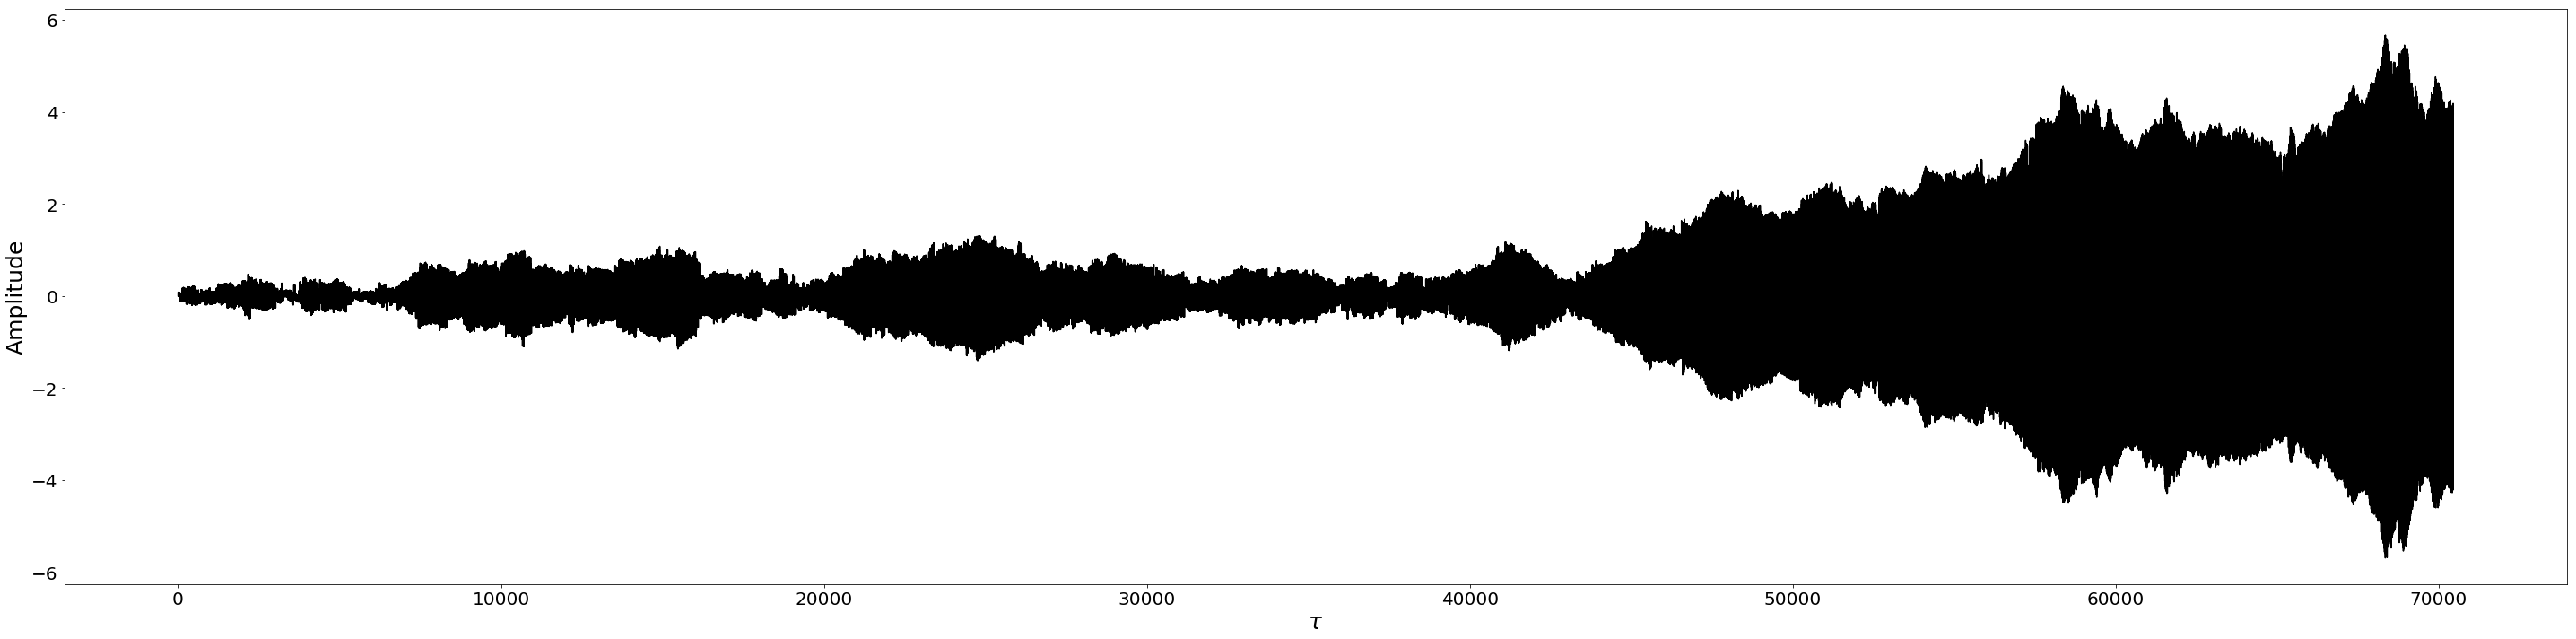

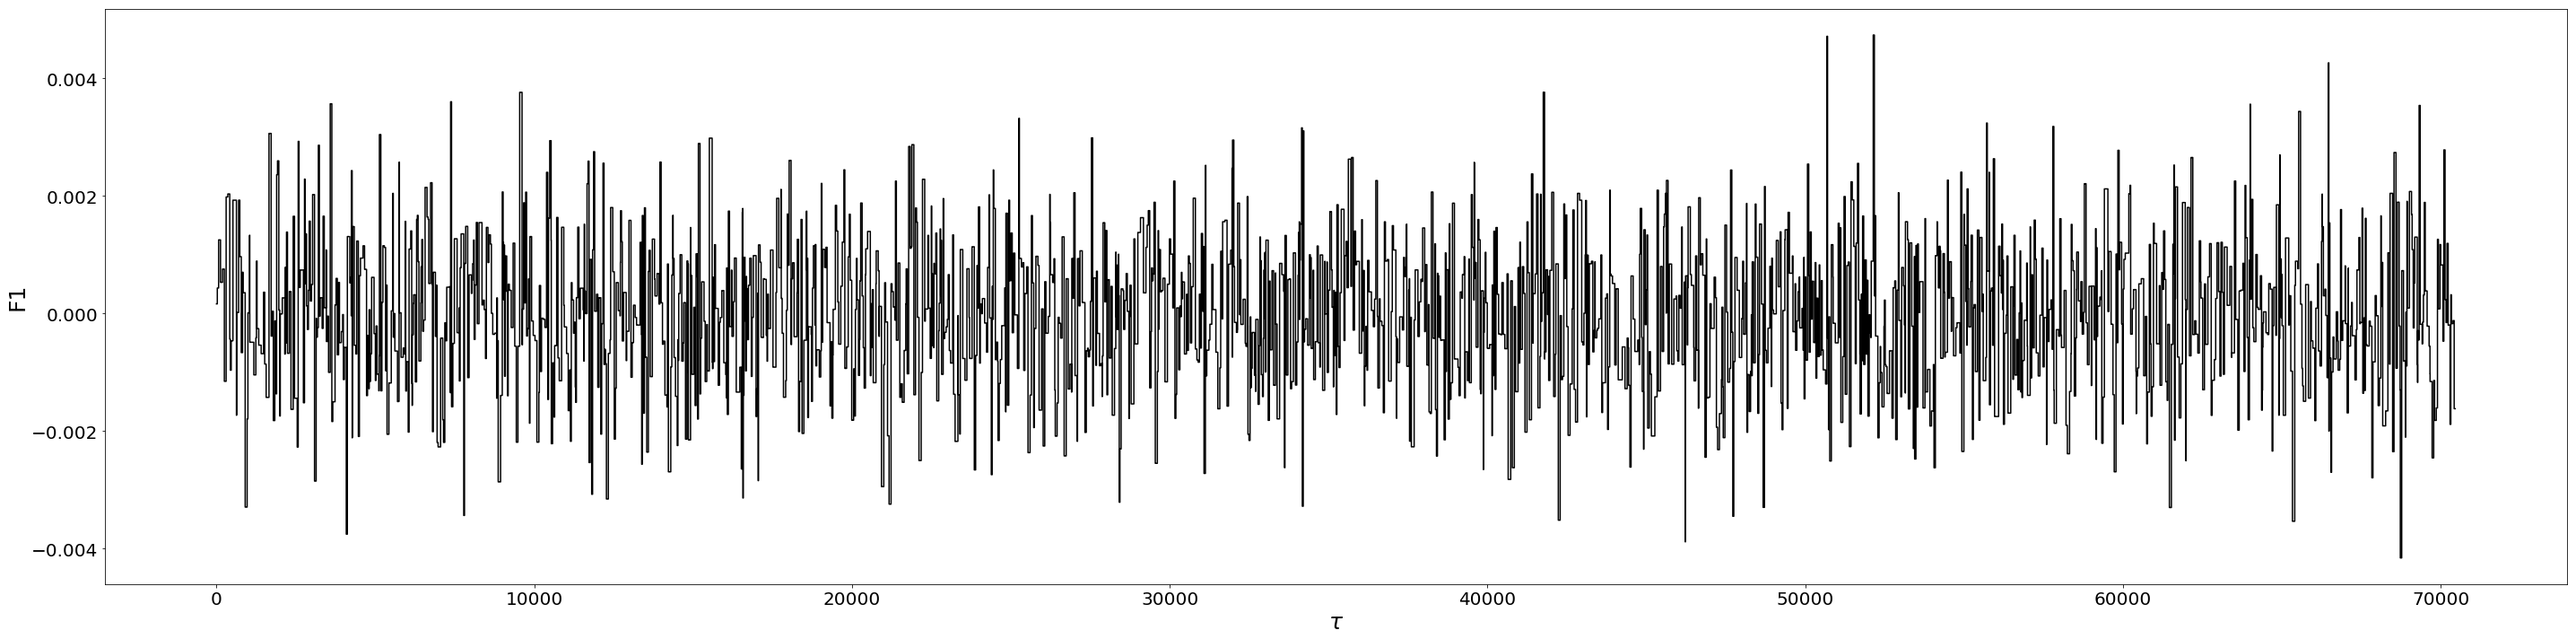

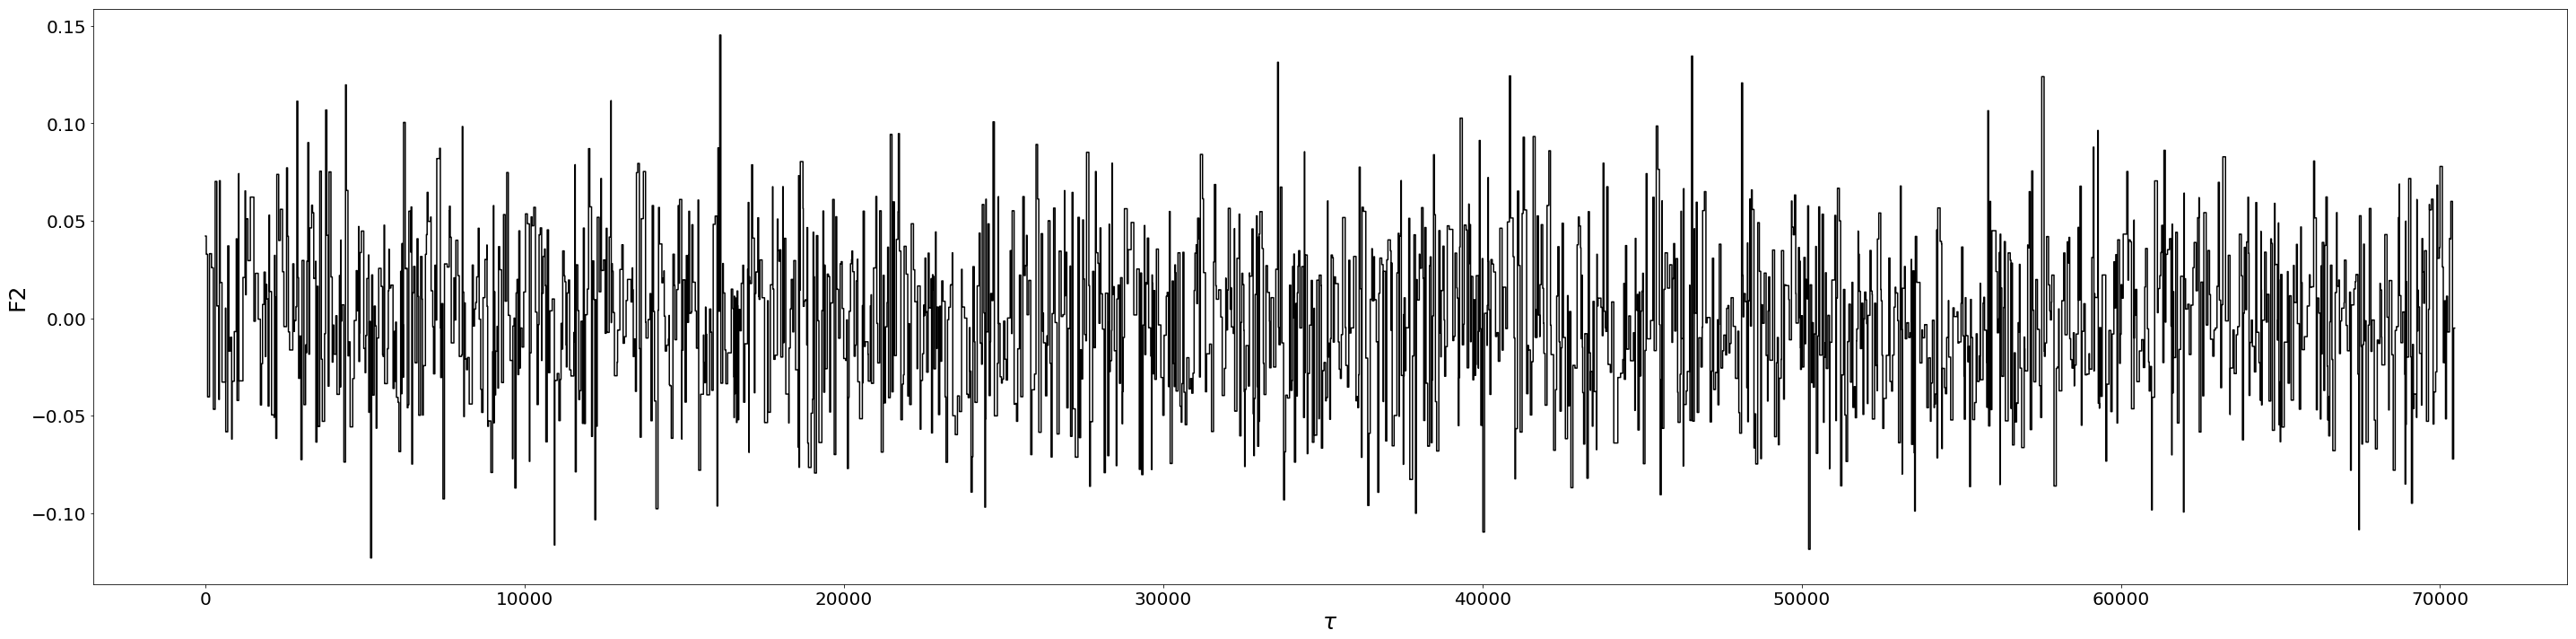



evolution  9


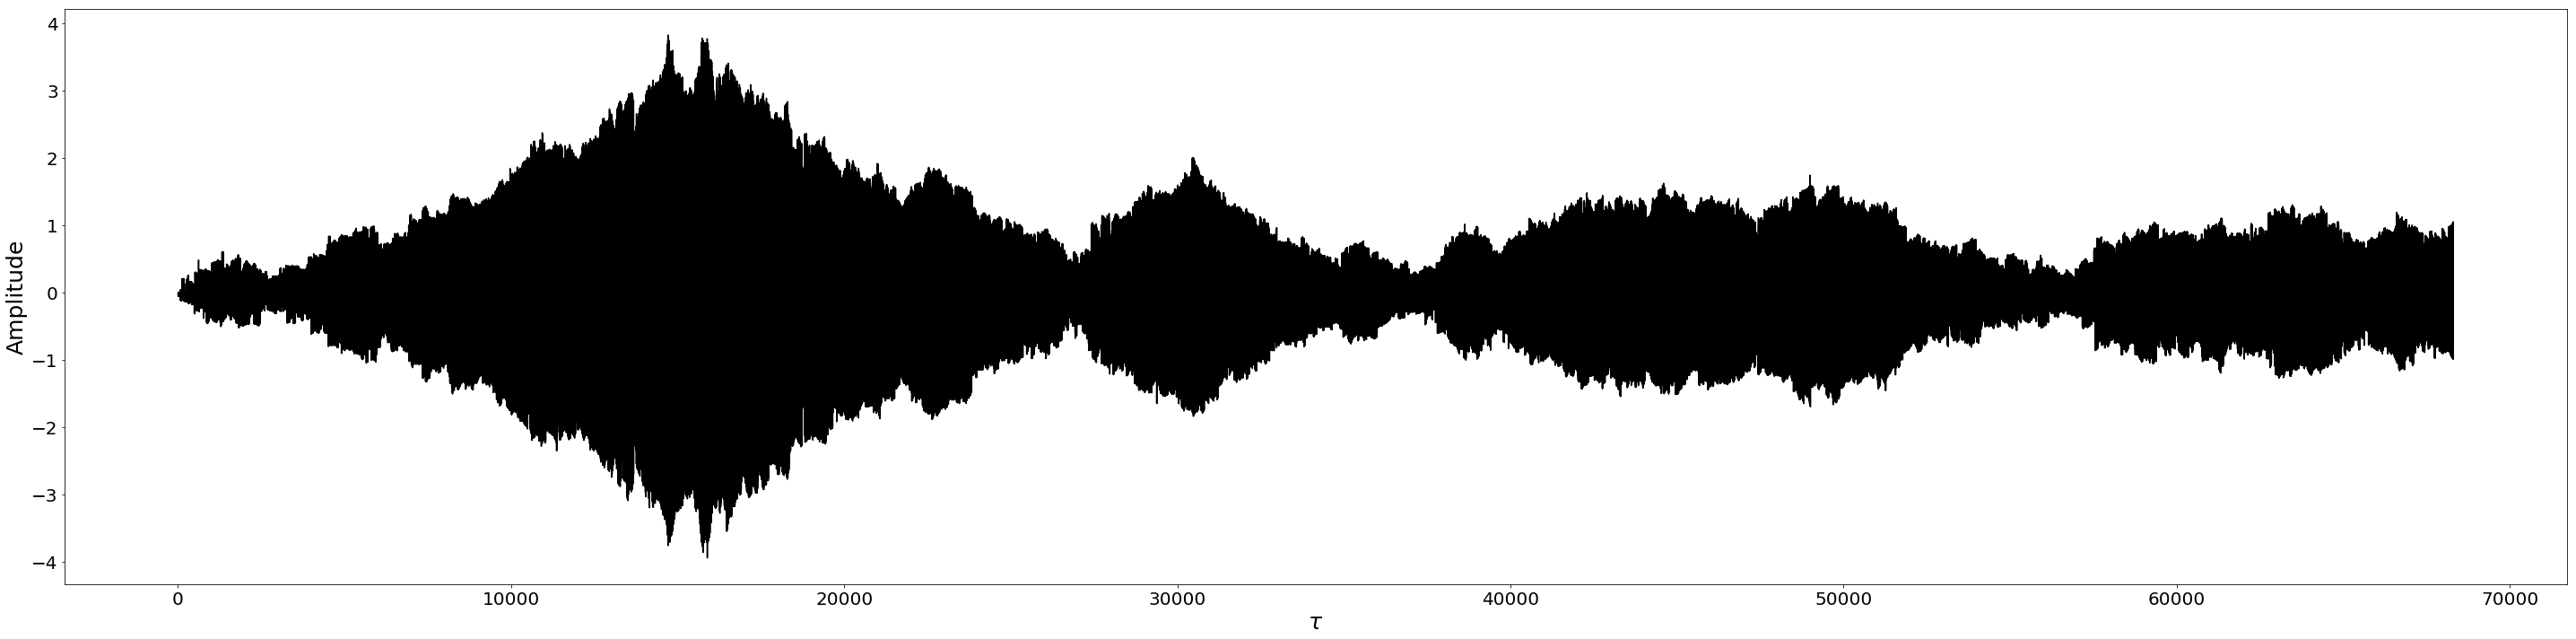

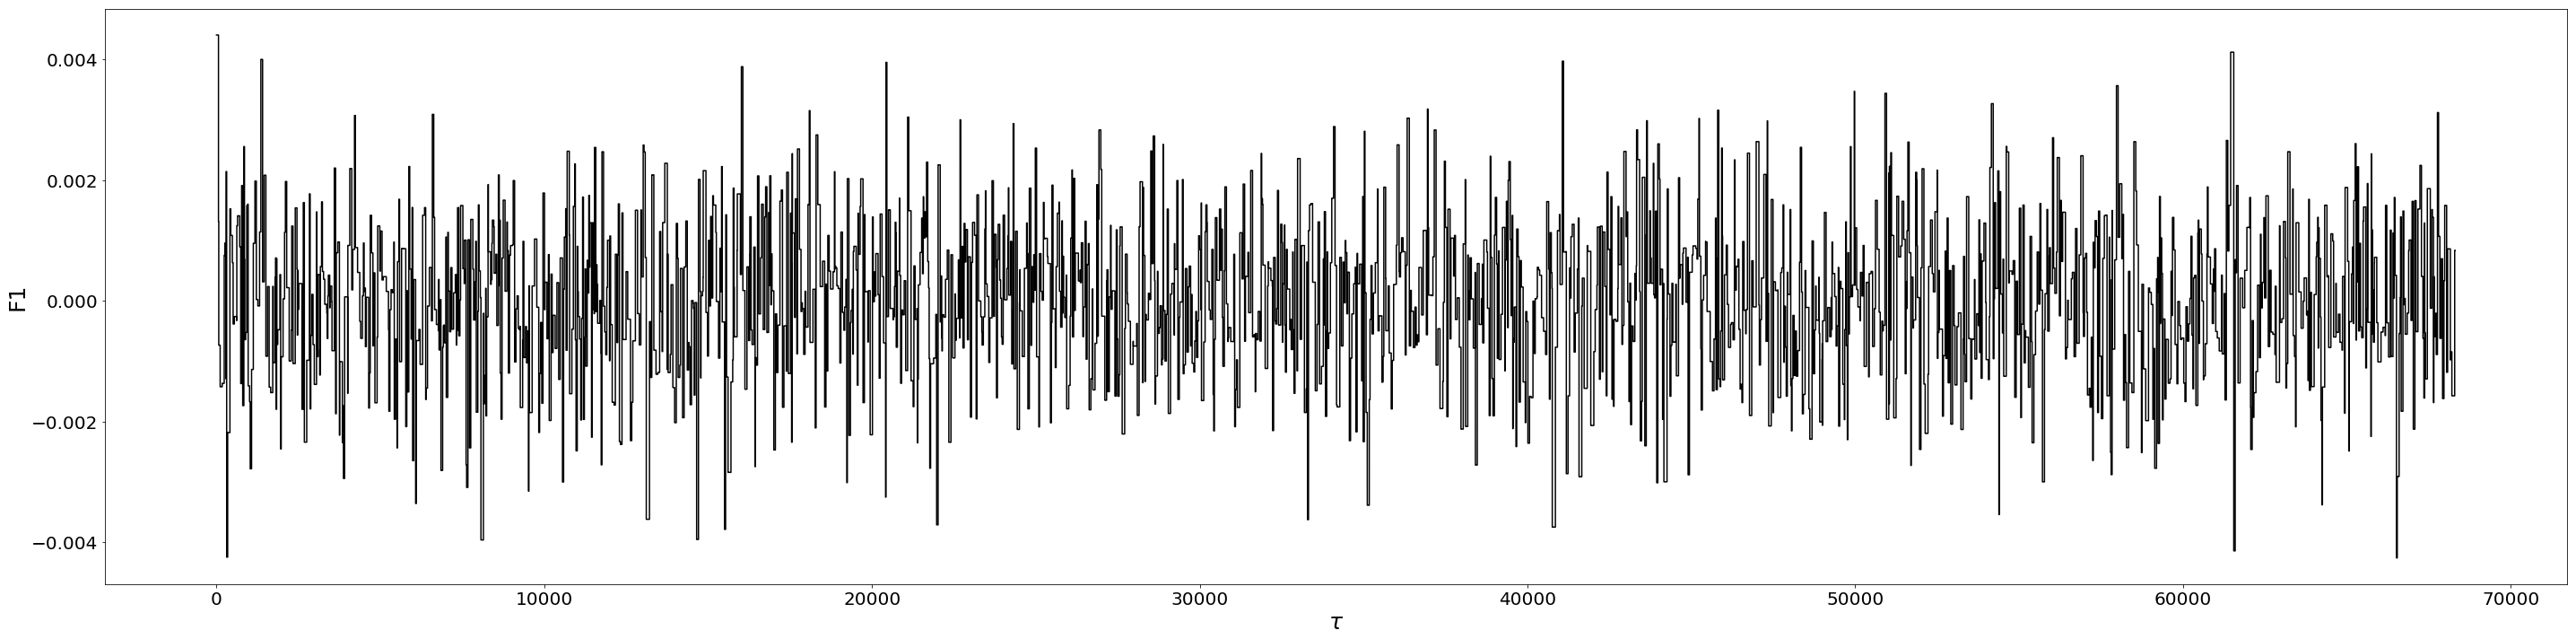

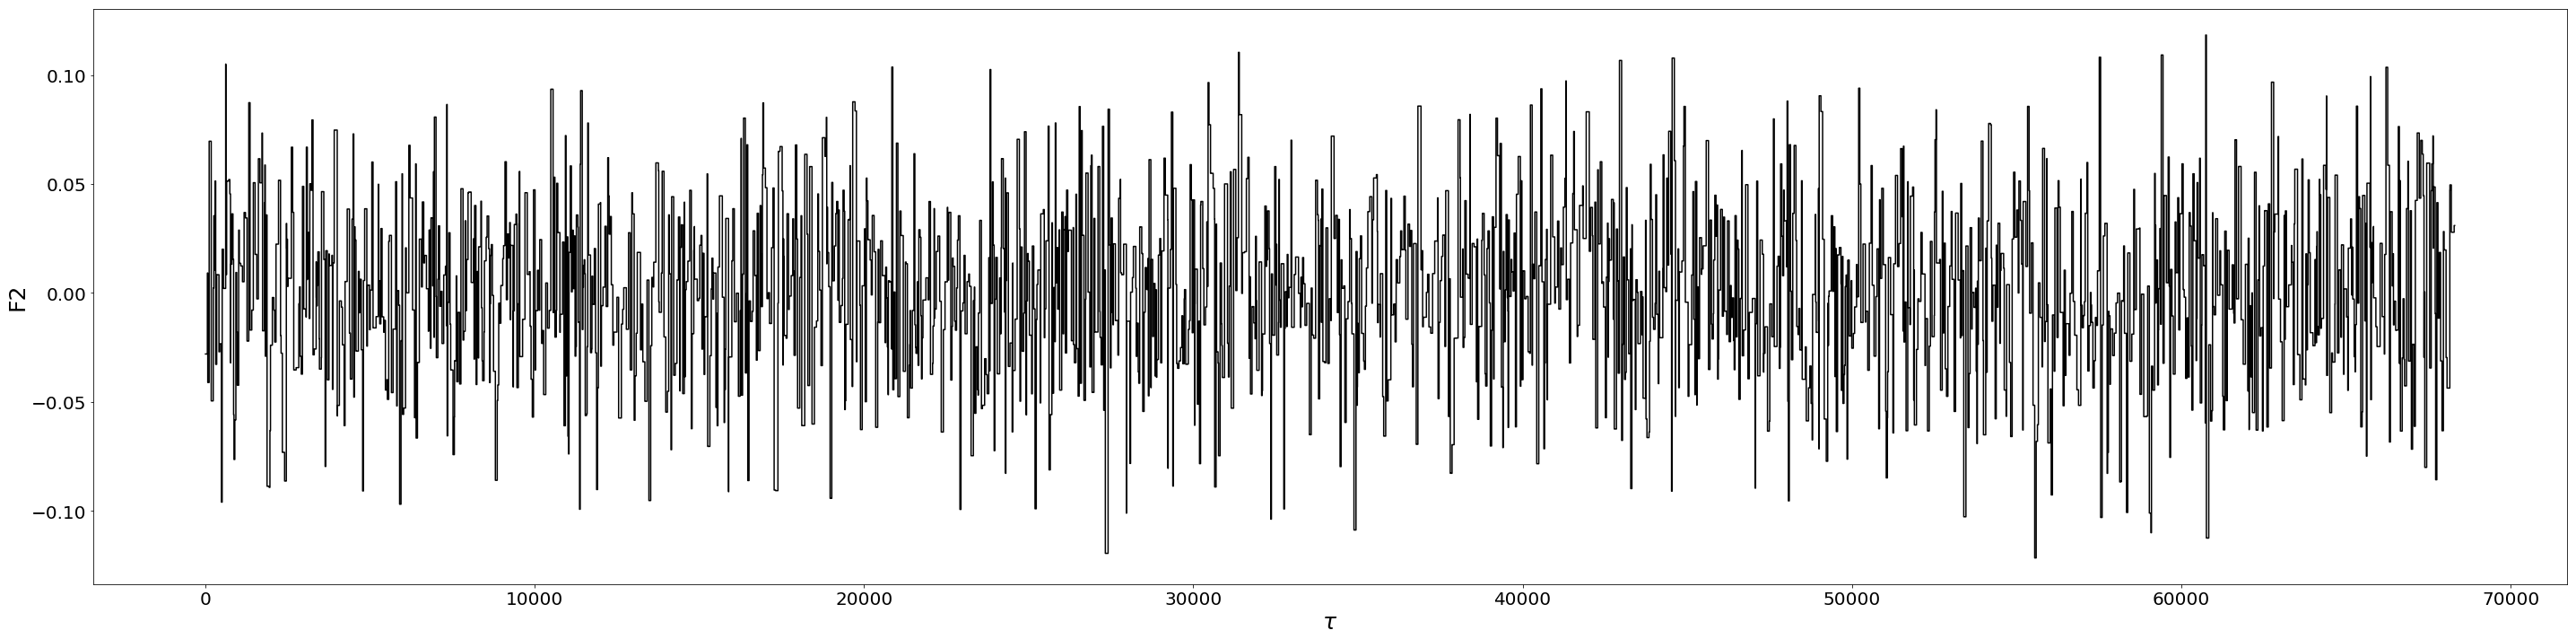



evolution  10


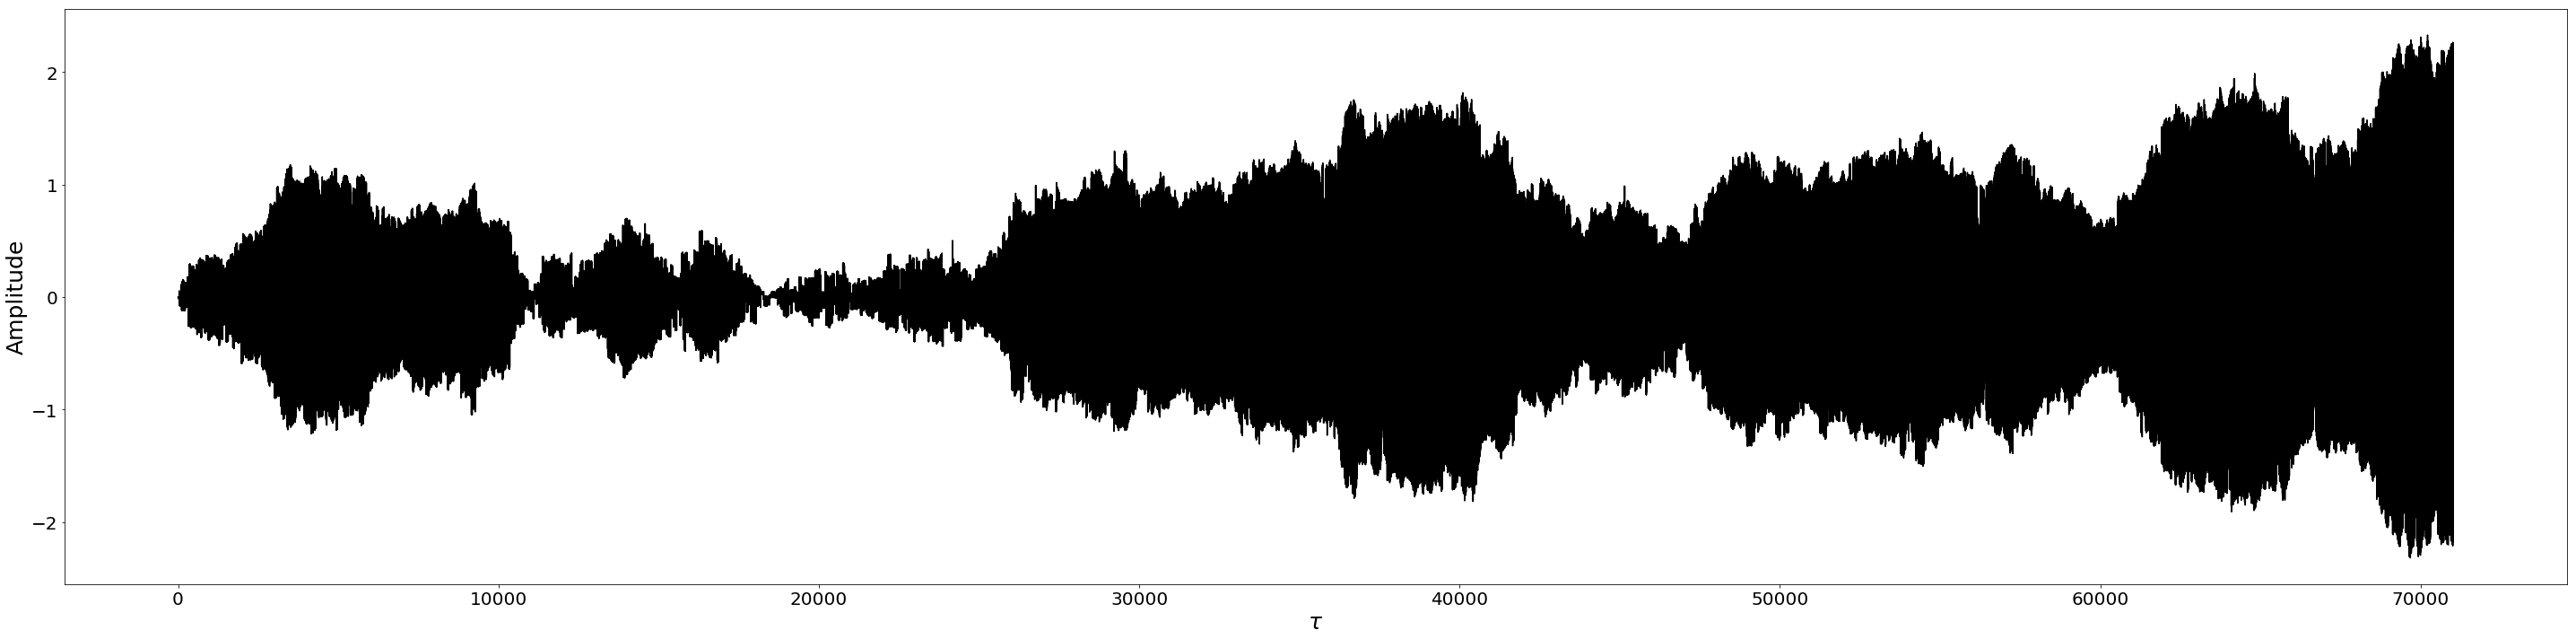

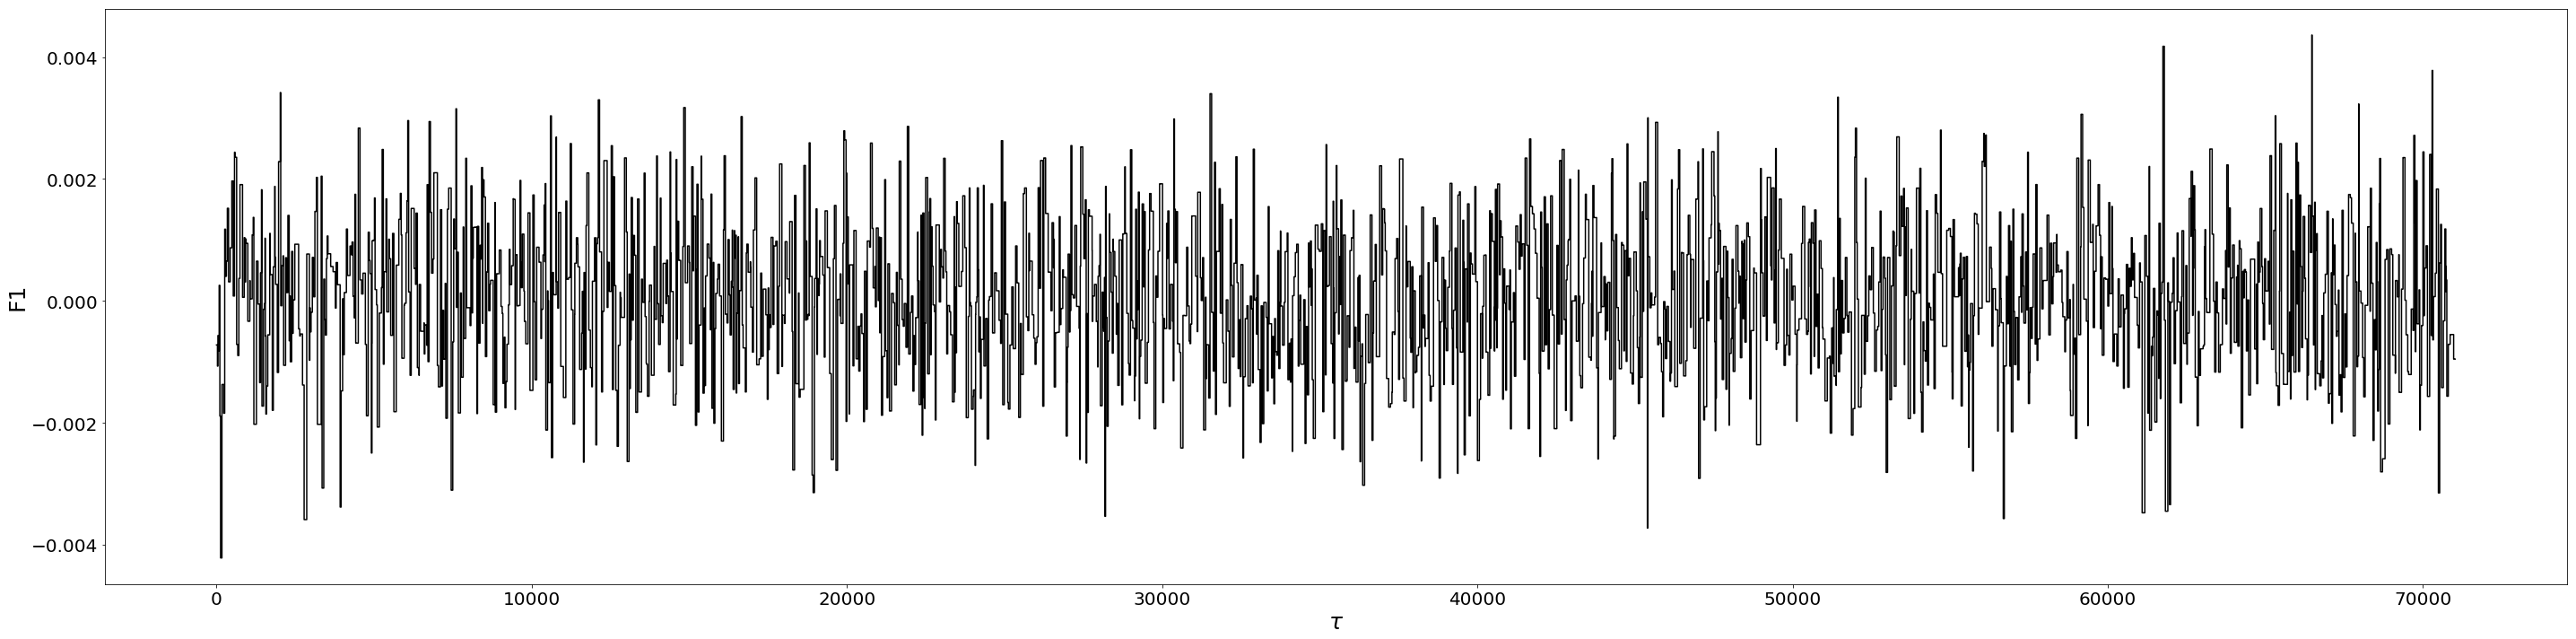

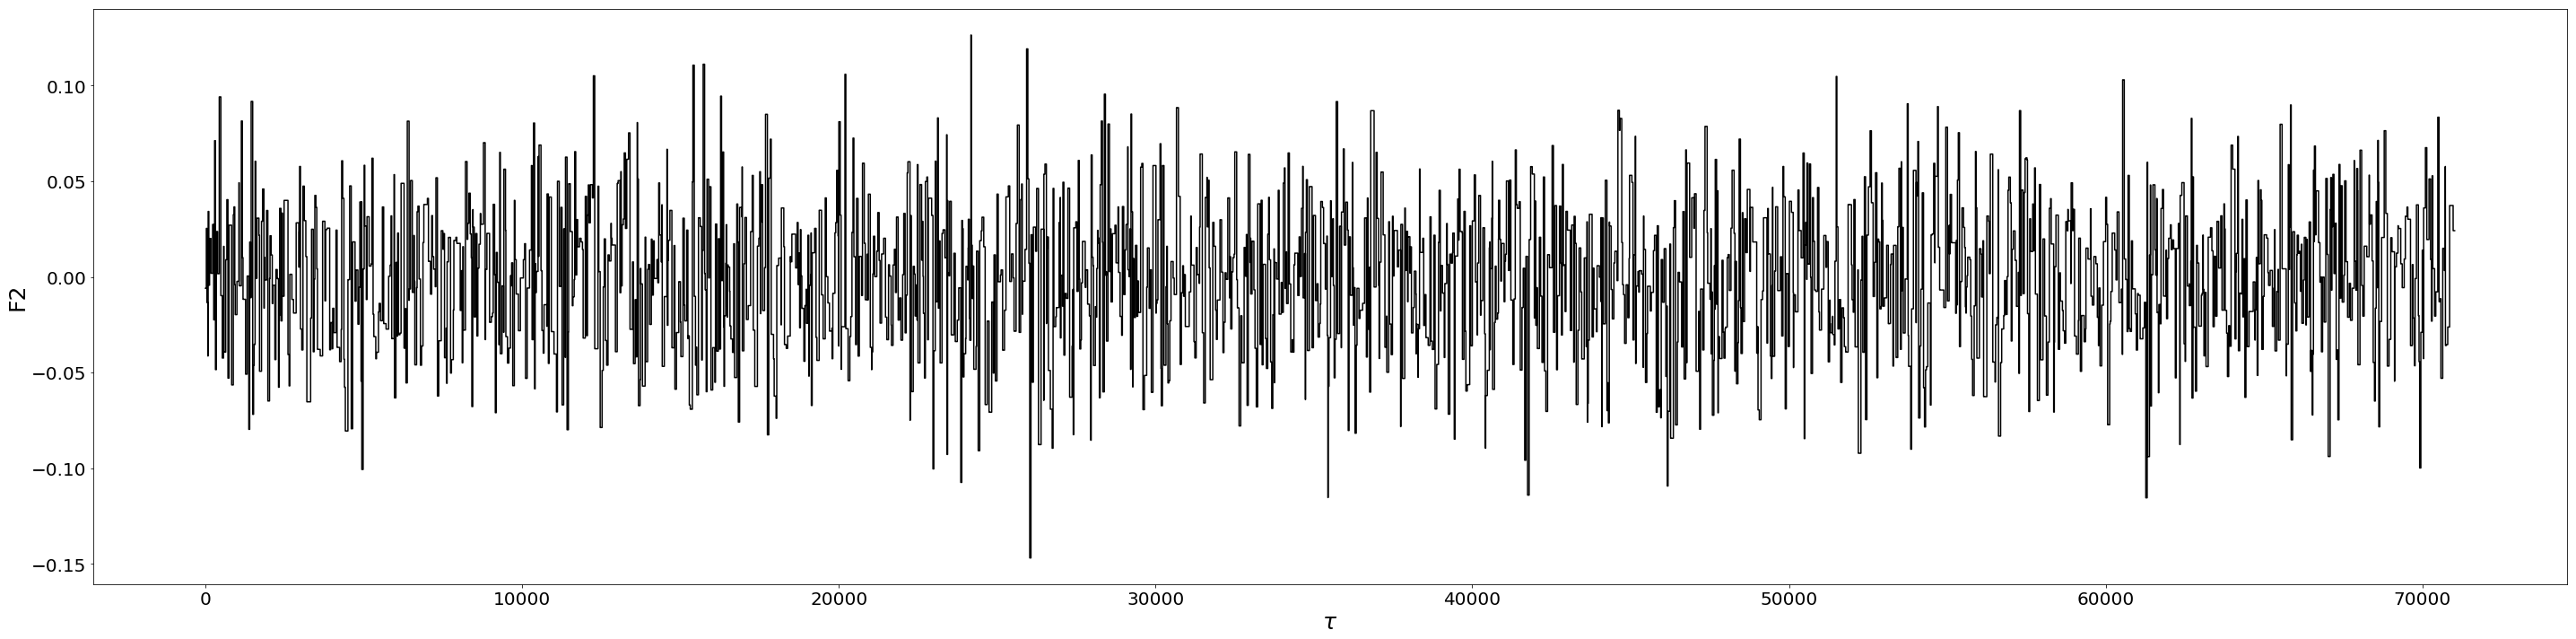

In [18]:
alpha = []
funAlpha(A, t, alpha)

print("evolution 1 above")
# collecting nmax values of alpha from L evolutions
for i in range(L-1):
    print("evolution ", i+2)
    deltaT = fundeltaT(n_bins, n_samples)
    Tturb, time = funTturb()
    t = funt()
    F2 = np.random.normal(meanF2, stdF2, size=len(deltaT))
    F1 = np.random.normal(meanF1, stdF1, size=len(deltaT))
    G1 = funG1(F1)
    A, t, f1, g1, f2 =funAmp(dAdT, AT)
    Funplots(t, A, f1, f2)
    funAlpha(A, t, alpha)
    print("\n")

alpha = flatten(alpha)


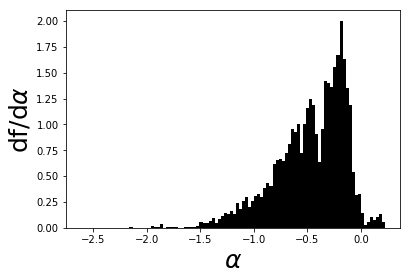

In [19]:
# divide the full range alpha_min <= alpha <= alpha_max into n equal intervals
# delalpha = (alpha_max - alpha_min) / n ~ 4/n
alpha_max = max(alpha)
alpha_min = min(alpha)
delalpha = (alpha_max - alpha_min) / m

# we want n(max) << number of samples = L * T(max)/delT = L * M / N
nmax = L * M / N

# plot delf / delalpha vs. alpha
# where delf is the fraction of collected values of alpha within each bin of width delalpha

histogram = plt.hist(alpha, m, density=True, color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('df/d'r'$ \alpha $', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Cumulative Distribution Function

In [20]:
# CDF2 = int (df/dalpha) wrt dalpha from alpha to alpha_max
#      = 1 - CDF1
#      = 1 - int (df/dalpha) wrt dalpha from alpha_min to alpha

CDF2 = []
CDF1 = []

# alpha and dfdalpha values pulled from histogram above
alpha_values = histogram[1]
dfdalpha = histogram[0]
alpha_values = np.delete(alpha_values, 0)

index_max = len(alpha_values)-1

for index in range(len(dfdalpha)):
    index_start = index
    sum = 0
    for index_current in range(index_start, index_max):
        sum += dfdalpha[index_current] * alpha_values[index_current]
    CDF2.append(1-sum)
    CDF1.append(sum)
    
normalization_factor = CDF2[0]

CDF2_norm = []
for value in CDF2:
    CDF2_norm.append(value/normalization_factor)
    
CDF1_norm = []
for value in CDF1:
    CDF1_norm.append((value/normalization_factor)+1)
    
CDF2_norm = np.array(CDF2_norm)
CDF1_norm = np.array(CDF1_norm)

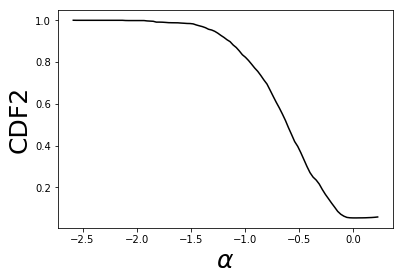

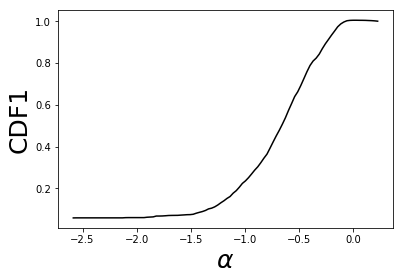

In [21]:
plt.plot(alpha_values, CDF2_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF2', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

plt.plot(alpha_values, CDF1_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF1', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()